In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image
import os

import torch
from torchvision import models, transforms
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim

import matplotlib.pyplot as plotter_lib

from torch.utils.data import DataLoader,Dataset
import torchvision.transforms.functional as TF

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import pandas as pd

torch.autograd.set_detect_anomaly(True)

import wandb

# Initialize WandB project
wandb.init(
    project='srgan-training', 
    job_type="training", 
    anonymous="allow"
)

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.


wandb: Currently logged in as: dnicho26 (dnicho26-university-of-north-carolina-at-charlotte). Use `wandb login --relogin` to force relogin


wandb: Tracking run with wandb version 0.18.5


wandb: Run data is saved locally in /opt/notebooks/Applied-AI-Midterm/wandb/run-20241026_230218-ttqlol28
wandb: Run `wandb offline` to turn off syncing.


wandb: Syncing run resilient-plasma-2


wandb: ⭐️ View project at https://wandb.ai/dnicho26-university-of-north-carolina-at-charlotte/srgan-training


wandb: 🚀 View run at https://wandb.ai/dnicho26-university-of-north-carolina-at-charlotte/srgan-training/runs/ttqlol28


In [2]:
print(torch.cuda.is_available())

# Storing ID of current CUDA device
cuda_id = torch.cuda.current_device()
print(torch.cuda.get_device_name(cuda_id))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

True
Tesla P100-PCIE-16GB


In [3]:
# Define the data transforms to be applied to the images
train_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
test_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [4]:
from turbojpeg import TurboJPEG

# Specify the path to the turbojpeg library
lib_path = r'/opt/conda/envs/CC-Chatbot/lib/libturbojpeg.so'
jpeg = TurboJPEG(lib_path)

# Define the dataset class
class CatsDogsDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        # Load image using TurboJPEG
        image_path = self.image_paths[index]
        with open(image_path, 'rb') as image_file:
            image_data = image_file.read()
            image = jpeg.decode(image_data)
            image = Image.fromarray(image)

        # Apply transformations if provided
        if self.transform:
            image = self.transform(image)

        # Resize the high-resolution image to low-resolution
        image_low = transforms.Resize((32, 32))(image)

        label = self.labels[index]

        return image_low, image, label

In [5]:
# Set the main directory for the dataset
main_dir = r'./Data/train'
print("Initializing DataLoader...")

image_paths = []
labels = []
for image_name in os.listdir(main_dir):
    if image_name.startswith("cat"):
        label = 0  # Label for cat
    elif image_name.startswith("dog"):
        label = 1  # Label for dog
    else:
        continue

    image_path = os.path.join(main_dir, image_name)
    image_paths.append(image_path)
    labels.append(label)


# Split the dataset into training and testing (70/30 split)
train_paths, test_paths, train_labels, test_labels = train_test_split(image_paths, labels, test_size=0.3, random_state=42)

# Create dataset instances for train and test
image_datasets = {
    'train': CatsDogsDataset(train_paths, train_labels, transform=train_transform),
    'test': CatsDogsDataset(test_paths, test_labels, transform=test_transform)
}

# Create DataLoaders for the datasets
dataloaders = {
    'train': DataLoader(image_datasets['train'], batch_size=32, shuffle=True, num_workers=0, pin_memory=False),
    'test': DataLoader(image_datasets['test'], batch_size=32, shuffle=False, num_workers=0, pin_memory=False)
}

image_low, image_high, labels = next(iter(dataloaders['train']))

# Print the number of images in the train and test sets
print(f"Number of images in train set: {len(image_datasets['train'])}")
print(f"Number of images in test set: {len(image_datasets['test'])}")


Initializing DataLoader...


Number of images in train set: 17500
Number of images in test set: 7500


In [6]:
print(image_low.shape)
print(image_high.shape)

torch.Size([32, 3, 32, 32])
torch.Size([32, 3, 128, 128])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0203922..2.3393636].


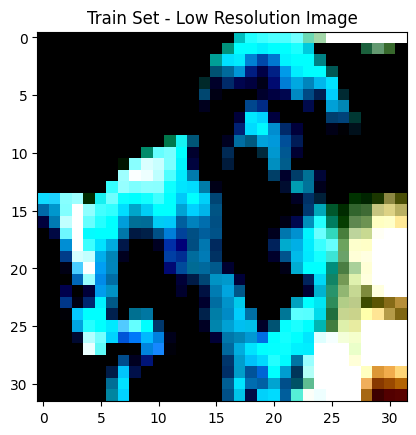

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0836544..2.4831376].


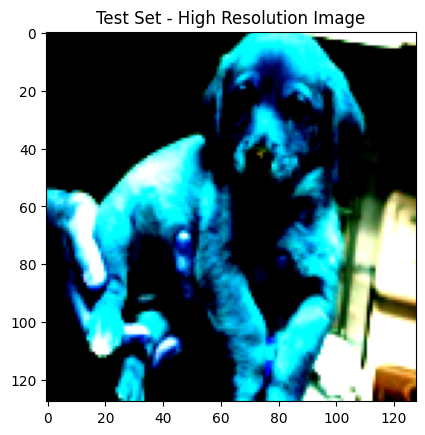

In [7]:
import matplotlib.pyplot as plt

# Display an image from the train set
plt.imshow(image_low[0].permute(1,2,0))
plt.title('Train Set - Low Resolution Image')
plt.show()

# Display an image from the test set
plt.imshow(image_high[0].permute(1,2,0))
plt.title('Test Set - High Resolution Image')
plt.show()


In [8]:
# Define a function to visualize a low-resolution image, a high-resolution image, and a generated image.
def visualize(lr_image, hr_image, generated_image, label, epoch, pretrain, show=False):
    # Move the tensors to the CPU and detach the generated_image tensor.
    lr_image = lr_image.cpu().detach().permute(1, 2, 0).numpy()
    hr_image = hr_image.cpu().detach().permute(1, 2, 0).numpy()
    generated_image = generated_image.cpu().detach().permute(1, 2, 0).numpy()

    # Normalize the pixel values to the range [0, 1] for visualization.
    lr_image = (lr_image - lr_image.min()) / (lr_image.max() - lr_image.min())
    hr_image = (hr_image - hr_image.min()) / (hr_image.max() - hr_image.min())
    generated_image = (generated_image - generated_image.min()) / (generated_image.max() - generated_image.min())

    # Plot the images.
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 15))
    axes[0].imshow(lr_image)
    axes[0].set_title("Low Resolution")
    axes[1].imshow(hr_image)
    axes[1].set_title("High Resolution")
    axes[2].imshow(generated_image)
    axes[2].set_title("Generated Image")

    # Add some padding to the top of the figure.
    fig.subplots_adjust(top=0.85)

    # Add a common title to the figure depending on the pretrain flag.
    if pretrain:
        fig.suptitle(f" Epoch {epoch} - {label}")
    else:
        fig.suptitle(f"Epoch {epoch} - {label}")
    
    # Create the 'output' directory if it doesn't exist.
    if not os.path.exists('./output'):
        os.makedirs('./output')
    
    # Save and show the figure every 5 epochs or if the show flag is set to True.
    if epoch % 5 == 0 or show:
        fig.savefig(f"./output/epoch_{epoch}_{label}.png")
        plt.show()
    else:
        plt.close(fig)

In [9]:
class residual(nn.Module):
    def __init__(self, num_res_blocks=16):
        super().__init__()
        self.num_res_blocks = num_res_blocks
        
        # First layer
        self.conv1 = nn.Sequential(
            nn.LazyConv2d(3, 64, kernel_size=9, padding=4),
            nn.PReLU()
        )
        
        # Add Residual blocks
        res_blocks = []
        for i in range(num_res_blocks):
            res_blocks.append(residual(64))
        self.res_blocks = nn.Sequential(*res_blocks)
        
        # Second conv layer post residual blocks
        self.conv2 = nn.Sequential(
            nn.LazyConv2d(64, 64, kernel_size=3, padding=1, stride=1),
            nn.LazyBatchNorm2d()
        )
        
        # Upsampling Layers
        upsample_layers = []
        for out_channels in [32, 16, 4]:
            upsample_layers += [
                nn.LazyConvTranspose2d(64, out_channels, kernel_size=3, stride=2, padding=1, output_padding=1),
                nn.PReLU()
            ]
        self.upsample_layers = nn.Sequential(*upsample_layers)
        
        # Final output layer
        self.output_layer = nn.Sequential(
            nn.LazyConv2d(4, 3, kernel_size=9, padding=4),
            nn.Tanh()
        )
        
    def forward(self, x):
        x = self.conv1(x)
        residual = x
        x = self.res_blocks(x)
        x = self.conv2(x)
        x += residual
        x = self.upsample_layers(x)
        x = self.output_layer(x)
        return x


In [10]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()

        self.generator = nn.Sequential(
            nn.LazyConv2d(64, kernel_size=9, stride=1, padding=4),
            nn.PReLU(),
            
            nn.LazyConv2d(64, kernel_size=3, padding=1, stride=1),
            nn.LazyBatchNorm2d(64),
            nn.PReLU(),
            
            nn.LazyConv2d(64, kernel_size=3, padding=1, stride=1),
            nn.LazyBatchNorm2d(64),
            nn.PReLU(),
            
            nn.LazyConv2d(64, kernel_size=3, padding=1, stride=1),
            nn.LazyBatchNorm2d(64),
            nn.PReLU(),
            
            nn.LazyConv2d(64, kernel_size=3, padding=1, stride=1),
            nn.LazyBatchNorm2d(64),
            nn.PReLU(),
            
            nn.LazyConv2d(64, kernel_size=3, padding=1, stride=1),
            nn.LazyBatchNorm2d(64),
            nn.PReLU(),
            
            nn.LazyConv2d(64, kernel_size=3, padding=1, stride=1),
            nn.LazyBatchNorm2d(),
            nn.PReLU(),
            
            nn.LazyConv2d(64, kernel_size=3, padding=1, stride=1),
            nn.LazyBatchNorm2d(),
            nn.PReLU(),
            
            nn.LazyConv2d(64, kernel_size=3, padding=1, stride=1),
            nn.LazyBatchNorm2d(),
            nn.PReLU(),
            
            nn.LazyConv2d(64, kernel_size=3, padding=1, stride=1),
            nn.LazyBatchNorm2d(),
            nn.PReLU(),
            
            nn.LazyConv2d(64, kernel_size=3, padding=1, stride=1),
            nn.LazyBatchNorm2d(),
            nn.PReLU(),
            
            nn.LazyConv2d(64, kernel_size=3, padding=1, stride=1),
            nn.LazyBatchNorm2d(),
            nn.PReLU(),
            
            nn.LazyConv2d(64, kernel_size=3, padding=1, stride=1),
            nn.LazyBatchNorm2d(),
            nn.PReLU(),
            
            nn.LazyConv2d(256, kernel_size=3, padding=1, stride=1),
            torch.nn.PixelShuffle(2),
            nn.PReLU(),
            
            nn.LazyConv2d(256, kernel_size=3, padding=1, stride=1),
            torch.nn.PixelShuffle(2),
            nn.PReLU(),
            
            nn.LazyConv2d(3, kernel_size=9, stride=1, padding=4),
        )

    def forward(self, x):
        out = self.generator(x)

        return out


In [11]:
generator = Generator().to(device)
test_input = torch.rand(1,3,32,32).to(device)
print(generator(test_input).shape)

torch.Size([1, 3, 128, 128])


In [12]:
# Define a class for the pre-training generator
class pretraining_generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.pretrain = True
        self.mse_loss = nn.MSELoss()

    def forward(self, sr, hr):
        # Calculate the content loss between SR and HR images
        content_loss = self.mse_loss(sr, hr)
        return content_loss
    
import torch.nn.functional as F
from torchvision.models import vgg19

# Define a class for the generator loss function
class generator_loss(nn.Module):
    def __init__(self):
        super().__init__()
        # Load a VGG19 model pre-trained on ImageNet
        self.vgg = vgg19(pretrained=True).features[:35].eval()
        # Freeze the parameters of the VGG19 model
        for param in self.vgg.parameters():
            param.requires_grad = False
        self.mse_loss = nn.MSELoss()

    def forward(self, sr, hr, discriminator_fake_output):
        # Calculate the content loss between SR and HR images using the VGG19 model
        with torch.no_grad():
            hr_vgg = self.vgg(hr)
        sr_vgg = self.vgg(sr)
        content_loss = self.mse_loss(sr_vgg, hr_vgg)

        # Calculate the adversarial loss using the discriminator output
        adversarial_loss = F.binary_cross_entropy(discriminator_fake_output, torch.ones_like(discriminator_fake_output))

        # Calculate the total generator loss as a weighted sum of the content and adversarial losses
        generator_loss = content_loss + 1e-3 * adversarial_loss

        return generator_loss

In [13]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.body = nn.Sequential(
            nn.LazyConv2d(64, kernel_size=3, stride=1),
            nn.LazyBatchNorm2d(),
            nn.LeakyReLU(0.2),
            
            nn.LazyConv2d(64, kernel_size=3, stride=2),
            nn.LazyBatchNorm2d(),
            nn.LeakyReLU(0.2),
            
            nn.LazyConv2d(128, kernel_size=3, stride=1),
            nn.LazyBatchNorm2d(),
            nn.LeakyReLU(0.2),
            
            nn.LazyConv2d(128, kernel_size=3, stride=2),
            nn.LazyBatchNorm2d(),
            nn.LeakyReLU(0.2),
            
            nn.LazyConv2d(256, kernel_size=3, stride=1),
            nn.LazyBatchNorm2d(),
            nn.LeakyReLU(0.2),
            
            nn.LazyConv2d(256, kernel_size=3, stride=2),
            nn.LazyBatchNorm2d(),
            nn.LeakyReLU(0.2),
            
            nn.LazyConv2d(512, kernel_size=3, stride=1),
            nn.LazyBatchNorm2d(),
            nn.LeakyReLU(0.2),
            
            nn.LazyConv2d(512, kernel_size=3, stride=2),
            nn.LazyBatchNorm2d(),
            nn.LeakyReLU(0.2)
        )
            
       

        # Add the fully connected part before the final nn.Linear layer
        self.fc = nn.Sequential(
            nn.LazyLinear(1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        
        # Pass the output through the discriminator blocks (body)
        x = self.body(x)

        # Flatten the output
        x = x.view(x.size(0), -1)

        # Pass the output through the fully connected part
        x = self.fc(x)

        return x

In [14]:
class discriminator_loss(nn.Module):
    def __init__(self):
        super().__init__()
        self.bce_loss = nn.BCELoss()

    def forward(self, real_pred, fake_pred):
        real_label = torch.ones_like(real_pred)
        fake_label = torch.zeros_like(fake_pred)

        # Loss for real high-resolution images
        real_loss = self.bce_loss(real_pred, real_label)

        # Loss for generated high-resolution images
        fake_loss = self.bce_loss(fake_pred, fake_label)

        # Total discriminator loss
        total_loss = (real_loss + fake_loss) * 0.5
        return total_loss

In [15]:
discriminator = Discriminator().to(device)
test_input = torch.rand(1,3,128,128).to(device)
print(discriminator(test_input).shape)

torch.Size([1, 1])


In [16]:
# Create the 'models' directory if it doesn't exist
if not os.path.exists('./models'):
    os.makedirs('./models')

In [17]:
# Load the data
train_loader = dataloaders['train']
test_loader = dataloaders['test']
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the number of epochs and the batch size
num_epochs = 100 # 50 epochs of pretraining + 100 of both = 150 total epochs
batch_size = 48
lr = 0.0001
bar_width=150

# Define the loss functions
pretrain_generator_loss = pretraining_generator().to(device)
generator_loss_fn = generator_loss().to(device)
discriminator_loss_fn = discriminator_loss().to(device)

# Move the model parameters to the device
generator.to(device)
discriminator.to(device)

# Define the optimizers
generator_optimizer = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
discriminator_optimizer = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

# Load the data
train_loader = dataloaders['train']
test_loader = dataloaders['test']

pretrain_loss = []
generator_loss_history = []
discriminator_loss_history = []

# Watch the model with WandB
wandb.watch(generator, log="all")
wandb.watch(discriminator, log="all")

/opt/conda/envs/applied-ai/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/envs/applied-ai/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [18]:
# Pre-training phase
print("Starting pre-training phase...")
for epoch in range(50):
    generator.train()
    pbar = tqdm(total=len(train_loader), desc=f"Epoch {epoch+1}/50", ncols=bar_width)
    
    for i, (lr_images, hr_images, _) in enumerate(train_loader):
        # Move the data to the device
        lr_images = lr_images.to(device)
        hr_images = hr_images.to(device)

        # Generate the super-resolved images
        sr_images = generator(lr_images)

        # Compute the loss and update the parameters
        generator_loss_value = pretrain_generator_loss(sr_images, hr_images)
        generator_optimizer.zero_grad()
        generator_loss_value.backward(retain_graph=True)
        generator_optimizer.step()

        pretrain_loss.append(generator_loss_value.item())
        
        # Log loss to WandB
        wandb.log({"Pretrain Loss": generator_loss_value.item()})

        # Print the loss value every 10 batches
        if (i+1) % 10 == 0:
            pbar.set_postfix({"Gen loss": f"{generator_loss_value.item():.4f}"})
        pbar.update()

    pbar.close()

    # Save the generated images for visualization
    generator.eval()
    with torch.no_grad():
        lr_images, hr_images, _ = next(iter(test_loader))
        lr_images = lr_images.to(device)
        hr_images = hr_images.to(device)
        sr_images = generator(lr_images)
        visualize(lr_images[0], hr_images[0], sr_images[0], "Pre-Training", epoch+1, True)
        # Log the generated image to WandB
        wandb.log({"Generated Image": [wandb.Image(sr_images[0].cpu(), caption=f"Epoch {epoch+1}")]})
    # Save the generator model every 5 epochs
    if (epoch+1) % 5 == 0:
        torch.save(generator.state_dict(), f"./models/pretrain_generator_epoch_{epoch+1}.pt")
        wandb.save(f"./models/pretrain_generator_epoch_{epoch+1}.pt")
        
# Adversarial training phase
print("Starting adversarial training phase...")

for epoch in range(num_epochs):
    generator.train()
    discriminator.train()
    pbar = tqdm(total=len(train_loader), desc=f"Epoch {epoch+1}/{num_epochs}", ncols=bar_width)
    for i, (lr_images, hr_images, _) in enumerate(train_loader):
        # Move the data to the device
        lr_images = lr_images.to(device)
        hr_images = hr_images.to(device)

        # Generate the super-resolved images
        sr_images = generator(lr_images)

        # Train the discriminator
        discriminator_optimizer.zero_grad()
        real_labels = torch.ones(hr_images.size(0), 1).to(device)
        fake_labels = torch.zeros(hr_images.size(0), 1).to(device)
        discriminator_real_output = discriminator(hr_images)
        discriminator_fake_output = discriminator(sr_images)

        discriminator_real_loss = discriminator_loss_fn(discriminator_real_output, real_labels)
        discriminator_fake_loss = discriminator_loss_fn(discriminator_fake_output, fake_labels)
        discriminator_loss_value = discriminator_real_loss + discriminator_fake_loss
        discriminator_loss_value.backward()
        discriminator_optimizer.step()

        # Train the generator
        generator_optimizer.zero_grad()
        sr_images = generator(lr_images)
        discriminator_fake_output = discriminator(sr_images)
        generator_loss_value = generator_loss_fn(sr_images, hr_images, discriminator_fake_output)
        generator_loss_value.backward()
        generator_optimizer.step()

        discriminator_loss_history.append(discriminator_loss_value.item())
        generator_loss_history.append(generator_loss_value.item())

        # Log losses to WandB
        wandb.log({
            "Generator Loss": generator_loss_value.item(),
            "Discriminator Loss": discriminator_loss_value.item()
        })

        # Print the loss value every 10 batches
        if (i+1) % 10 == 0:
            pbar.set_postfix({"Gen loss": f"{generator_loss_value.item():.4f}", "Discr loss": f"{discriminator_loss_value.item():.4f}"})
        pbar.update()

    pbar.close()

    # Save the generator and discriminator models every 5 epochs
    if (epoch+1) % 5 == 0:
        torch.save(generator.state_dict(), f"./models/generator_epoch_{epoch+1}.pt")
        torch.save(discriminator.state_dict(), f"./models/discriminator_epoch_{epoch+1}.pt")
        wandb.save(f"./models/generator_epoch_{epoch+1}.pt")
        wandb.save(f"./models/discriminator_epoch_{epoch+1}.pt")

    # Save the generated images for visualization
    generator.eval()
    with torch.no_grad():
        lr_images, hr_images, _ = next(iter(test_loader))
        lr_images = lr_images.to(device)
        hr_images = hr_images.to(device)
        sr_images = generator(lr_images)
        visualize(lr_images[0], hr_images[0], sr_images[0], "Adversarial Training", epoch+1, True)
        # Log the generated image to WandB
        wandb.log({"Generated Image": [wandb.Image(sr_images[0].cpu(), caption=f"Epoch {epoch+1}")]})


Starting pre-training phase...


Epoch 1/50:   0%|                                                                                                             | 0/547 [00:00<?, ?it/s]

Epoch 1/50:   0%|▏                                                                                                    | 1/547 [00:03<29:17,  3.22s/it]

Epoch 1/50:   0%|▎                                                                                                    | 2/547 [00:06<30:56,  3.41s/it]

Epoch 1/50:   1%|▌                                                                                                    | 3/547 [00:10<32:22,  3.57s/it]

Epoch 1/50:   1%|▋                                                                                                    | 4/547 [00:13<28:40,  3.17s/it]

Epoch 1/50:   1%|▉                                                                                                    | 5/547 [00:16<30:03,  3.33s/it]

Epoch 1/50:   1%|█                                                                                                    | 6/547 [00:20<31:42,  3.52s/it]

Epoch 1/50:   1%|█▎                                                                                                   | 7/547 [00:24<32:55,  3.66s/it]

Epoch 1/50:   1%|█▍                                                                                                   | 8/547 [00:28<34:10,  3.80s/it]

Epoch 1/50:   2%|█▋                                                                                                   | 9/547 [00:32<35:30,  3.96s/it]

Epoch 1/50:   2%|█▍                                                                                  | 9/547 [00:36<35:30,  3.96s/it, Gen loss=1.1637]

Epoch 1/50:   2%|█▌                                                                                 | 10/547 [00:36<34:59,  3.91s/it, Gen loss=1.1637]

Epoch 1/50:   2%|█▋                                                                                 | 11/547 [00:40<34:55,  3.91s/it, Gen loss=1.1637]

Epoch 1/50:   2%|█▊                                                                                 | 12/547 [00:44<34:47,  3.90s/it, Gen loss=1.1637]

Epoch 1/50:   2%|█▉                                                                                 | 13/547 [00:48<35:48,  4.02s/it, Gen loss=1.1637]

Epoch 1/50:   3%|██                                                                                 | 14/547 [00:52<35:40,  4.02s/it, Gen loss=1.1637]

Epoch 1/50:   3%|██▎                                                                                | 15/547 [00:56<34:51,  3.93s/it, Gen loss=1.1637]

Epoch 1/50:   3%|██▍                                                                                | 16/547 [01:00<35:12,  3.98s/it, Gen loss=1.1637]

Epoch 1/50:   3%|██▌                                                                                | 17/547 [01:04<34:57,  3.96s/it, Gen loss=1.1637]

Epoch 1/50:   3%|██▋                                                                                | 18/547 [01:08<34:50,  3.95s/it, Gen loss=1.1637]

Epoch 1/50:   3%|██▉                                                                                | 19/547 [01:12<35:09,  3.99s/it, Gen loss=1.1637]

Epoch 1/50:   3%|██▉                                                                                | 19/547 [01:16<35:09,  3.99s/it, Gen loss=0.3953]

Epoch 1/50:   4%|███                                                                                | 20/547 [01:16<35:11,  4.01s/it, Gen loss=0.3953]

Epoch 1/50:   4%|███▏                                                                               | 21/547 [01:20<34:42,  3.96s/it, Gen loss=0.3953]

Epoch 1/50:   4%|███▎                                                                               | 22/547 [01:24<34:33,  3.95s/it, Gen loss=0.3953]

Epoch 1/50:   4%|███▍                                                                               | 23/547 [01:28<34:15,  3.92s/it, Gen loss=0.3953]

Epoch 1/50:   4%|███▋                                                                               | 24/547 [01:32<34:57,  4.01s/it, Gen loss=0.3953]

Epoch 1/50:   5%|███▊                                                                               | 25/547 [01:36<34:15,  3.94s/it, Gen loss=0.3953]

Epoch 1/50:   5%|███▉                                                                               | 26/547 [01:39<33:34,  3.87s/it, Gen loss=0.3953]

Epoch 1/50:   5%|████                                                                               | 27/547 [01:43<33:52,  3.91s/it, Gen loss=0.3953]

Epoch 1/50:   5%|████▏                                                                              | 28/547 [01:47<33:52,  3.92s/it, Gen loss=0.3953]

Epoch 1/50:   5%|████▍                                                                              | 29/547 [01:51<33:54,  3.93s/it, Gen loss=0.3953]

Epoch 1/50:   5%|████▍                                                                              | 29/547 [01:55<33:54,  3.93s/it, Gen loss=0.3512]

Epoch 1/50:   5%|████▌                                                                              | 30/547 [01:55<34:00,  3.95s/it, Gen loss=0.3512]

Epoch 1/50:   6%|████▋                                                                              | 31/547 [01:59<33:23,  3.88s/it, Gen loss=0.3512]

Epoch 1/50:   6%|████▊                                                                              | 32/547 [02:03<33:18,  3.88s/it, Gen loss=0.3512]

Epoch 1/50:   6%|█████                                                                              | 33/547 [02:07<32:43,  3.82s/it, Gen loss=0.3512]

Epoch 1/50:   6%|█████▏                                                                             | 34/547 [02:10<32:32,  3.81s/it, Gen loss=0.3512]

Epoch 1/50:   6%|█████▎                                                                             | 35/547 [02:14<32:53,  3.85s/it, Gen loss=0.3512]

Epoch 1/50:   7%|█████▍                                                                             | 36/547 [02:18<33:04,  3.88s/it, Gen loss=0.3512]

Epoch 1/50:   7%|█████▌                                                                             | 37/547 [02:22<33:33,  3.95s/it, Gen loss=0.3512]

Epoch 1/50:   7%|█████▊                                                                             | 38/547 [02:26<33:25,  3.94s/it, Gen loss=0.3512]

Epoch 1/50:   7%|█████▉                                                                             | 39/547 [02:31<34:17,  4.05s/it, Gen loss=0.3512]

Epoch 1/50:   7%|█████▉                                                                             | 39/547 [02:35<34:17,  4.05s/it, Gen loss=0.3259]

Epoch 1/50:   7%|██████                                                                             | 40/547 [02:35<34:13,  4.05s/it, Gen loss=0.3259]

Epoch 1/50:   7%|██████▏                                                                            | 41/547 [02:39<33:34,  3.98s/it, Gen loss=0.3259]

Epoch 1/50:   8%|██████▎                                                                            | 42/547 [02:42<31:10,  3.70s/it, Gen loss=0.3259]

Epoch 1/50:   8%|██████▌                                                                            | 43/547 [02:44<28:46,  3.43s/it, Gen loss=0.3259]

Epoch 1/50:   8%|██████▋                                                                            | 44/547 [02:47<27:15,  3.25s/it, Gen loss=0.3259]

Epoch 1/50:   8%|██████▊                                                                            | 45/547 [02:50<25:31,  3.05s/it, Gen loss=0.3259]

Epoch 1/50:   8%|██████▉                                                                            | 46/547 [02:53<24:48,  2.97s/it, Gen loss=0.3259]

Epoch 1/50:   9%|███████▏                                                                           | 47/547 [02:55<24:38,  2.96s/it, Gen loss=0.3259]

Epoch 1/50:   9%|███████▎                                                                           | 48/547 [02:59<25:55,  3.12s/it, Gen loss=0.3259]

Epoch 1/50:   9%|███████▍                                                                           | 49/547 [03:03<28:34,  3.44s/it, Gen loss=0.3259]

Epoch 1/50:   9%|███████▍                                                                           | 49/547 [03:06<28:34,  3.44s/it, Gen loss=0.3162]

Epoch 1/50:   9%|███████▌                                                                           | 50/547 [03:06<26:31,  3.20s/it, Gen loss=0.3162]

Epoch 1/50:   9%|███████▋                                                                           | 51/547 [03:09<25:20,  3.07s/it, Gen loss=0.3162]

Epoch 1/50:  10%|███████▉                                                                           | 52/547 [03:11<24:28,  2.97s/it, Gen loss=0.3162]

Epoch 1/50:  10%|████████                                                                           | 53/547 [03:14<24:17,  2.95s/it, Gen loss=0.3162]

Epoch 1/50:  10%|████████▏                                                                          | 54/547 [03:18<26:43,  3.25s/it, Gen loss=0.3162]

Epoch 1/50:  10%|████████▎                                                                          | 55/547 [03:22<27:31,  3.36s/it, Gen loss=0.3162]

Epoch 1/50:  10%|████████▍                                                                          | 56/547 [03:26<28:34,  3.49s/it, Gen loss=0.3162]

Epoch 1/50:  10%|████████▋                                                                          | 57/547 [03:30<29:40,  3.63s/it, Gen loss=0.3162]

Epoch 1/50:  11%|████████▊                                                                          | 58/547 [03:33<30:08,  3.70s/it, Gen loss=0.3162]

Epoch 1/50:  11%|████████▉                                                                          | 59/547 [03:37<30:16,  3.72s/it, Gen loss=0.3162]

Epoch 1/50:  11%|████████▉                                                                          | 59/547 [03:41<30:16,  3.72s/it, Gen loss=0.3167]

Epoch 1/50:  11%|█████████                                                                          | 60/547 [03:41<31:04,  3.83s/it, Gen loss=0.3167]

Epoch 1/50:  11%|█████████▎                                                                         | 61/547 [03:45<31:16,  3.86s/it, Gen loss=0.3167]

Epoch 1/50:  11%|█████████▍                                                                         | 62/547 [03:50<32:22,  4.01s/it, Gen loss=0.3167]

Epoch 1/50:  12%|█████████▌                                                                         | 63/547 [03:54<32:20,  4.01s/it, Gen loss=0.3167]

Epoch 1/50:  12%|█████████▋                                                                         | 64/547 [03:57<31:49,  3.95s/it, Gen loss=0.3167]

Epoch 1/50:  12%|█████████▊                                                                         | 65/547 [04:01<31:31,  3.92s/it, Gen loss=0.3167]

Epoch 1/50:  12%|██████████                                                                         | 66/547 [04:05<30:56,  3.86s/it, Gen loss=0.3167]

Epoch 1/50:  12%|██████████▏                                                                        | 67/547 [04:09<30:40,  3.83s/it, Gen loss=0.3167]

Epoch 1/50:  12%|██████████▎                                                                        | 68/547 [04:12<28:53,  3.62s/it, Gen loss=0.3167]

Epoch 1/50:  13%|██████████▍                                                                        | 69/547 [04:15<28:20,  3.56s/it, Gen loss=0.3167]

Epoch 1/50:  13%|██████████▍                                                                        | 69/547 [04:19<28:20,  3.56s/it, Gen loss=0.2719]

Epoch 1/50:  13%|██████████▌                                                                        | 70/547 [04:19<28:47,  3.62s/it, Gen loss=0.2719]

Epoch 1/50:  13%|██████████▊                                                                        | 71/547 [04:23<29:25,  3.71s/it, Gen loss=0.2719]

Epoch 1/50:  13%|██████████▉                                                                        | 72/547 [04:27<29:24,  3.71s/it, Gen loss=0.2719]

Epoch 1/50:  13%|███████████                                                                        | 73/547 [04:31<29:49,  3.77s/it, Gen loss=0.2719]

Epoch 1/50:  14%|███████████▏                                                                       | 74/547 [04:34<28:54,  3.67s/it, Gen loss=0.2719]

Epoch 1/50:  14%|███████████▍                                                                       | 75/547 [04:38<29:22,  3.73s/it, Gen loss=0.2719]

Epoch 1/50:  14%|███████████▌                                                                       | 76/547 [04:42<29:37,  3.77s/it, Gen loss=0.2719]

Epoch 1/50:  14%|███████████▋                                                                       | 77/547 [04:46<29:59,  3.83s/it, Gen loss=0.2719]

Epoch 1/50:  14%|███████████▊                                                                       | 78/547 [04:49<29:40,  3.80s/it, Gen loss=0.2719]

Epoch 1/50:  14%|███████████▉                                                                       | 79/547 [04:53<29:28,  3.78s/it, Gen loss=0.2719]

Epoch 1/50:  14%|███████████▉                                                                       | 79/547 [04:57<29:28,  3.78s/it, Gen loss=0.3000]

Epoch 1/50:  15%|████████████▏                                                                      | 80/547 [04:57<29:07,  3.74s/it, Gen loss=0.3000]

Epoch 1/50:  15%|████████████▎                                                                      | 81/547 [05:01<29:26,  3.79s/it, Gen loss=0.3000]

Epoch 1/50:  15%|████████████▍                                                                      | 82/547 [05:04<29:15,  3.77s/it, Gen loss=0.3000]

Epoch 1/50:  15%|████████████▌                                                                      | 83/547 [05:08<29:21,  3.80s/it, Gen loss=0.3000]

Epoch 1/50:  15%|████████████▋                                                                      | 84/547 [05:12<29:34,  3.83s/it, Gen loss=0.3000]

Epoch 1/50:  16%|████████████▉                                                                      | 85/547 [05:16<30:20,  3.94s/it, Gen loss=0.3000]

Epoch 1/50:  16%|█████████████                                                                      | 86/547 [05:20<30:04,  3.91s/it, Gen loss=0.3000]

Epoch 1/50:  16%|█████████████▏                                                                     | 87/547 [05:24<29:49,  3.89s/it, Gen loss=0.3000]

Epoch 1/50:  16%|█████████████▎                                                                     | 88/547 [05:28<29:58,  3.92s/it, Gen loss=0.3000]

Epoch 1/50:  16%|█████████████▌                                                                     | 89/547 [05:32<30:06,  3.94s/it, Gen loss=0.3000]

Epoch 1/50:  16%|█████████████▌                                                                     | 89/547 [05:35<30:06,  3.94s/it, Gen loss=0.3131]

Epoch 1/50:  16%|█████████████▋                                                                     | 90/547 [05:35<27:23,  3.60s/it, Gen loss=0.3131]

Epoch 1/50:  17%|█████████████▊                                                                     | 91/547 [05:37<24:56,  3.28s/it, Gen loss=0.3131]

Epoch 1/50:  17%|█████████████▉                                                                     | 92/547 [05:40<23:16,  3.07s/it, Gen loss=0.3131]

Epoch 1/50:  17%|██████████████                                                                     | 93/547 [05:42<21:47,  2.88s/it, Gen loss=0.3131]

Epoch 1/50:  17%|██████████████▎                                                                    | 94/547 [05:45<21:22,  2.83s/it, Gen loss=0.3131]

Epoch 1/50:  17%|██████████████▍                                                                    | 95/547 [05:48<21:17,  2.83s/it, Gen loss=0.3131]

Epoch 1/50:  18%|██████████████▌                                                                    | 96/547 [05:51<21:58,  2.92s/it, Gen loss=0.3131]

Epoch 1/50:  18%|██████████████▋                                                                    | 97/547 [05:55<24:43,  3.30s/it, Gen loss=0.3131]

Epoch 1/50:  18%|██████████████▊                                                                    | 98/547 [06:00<26:52,  3.59s/it, Gen loss=0.3131]

Epoch 1/50:  18%|███████████████                                                                    | 99/547 [06:03<27:20,  3.66s/it, Gen loss=0.3131]

Epoch 1/50:  18%|███████████████                                                                    | 99/547 [06:08<27:20,  3.66s/it, Gen loss=0.1836]

Epoch 1/50:  18%|██████████████▉                                                                   | 100/547 [06:08<28:23,  3.81s/it, Gen loss=0.1836]

Epoch 1/50:  18%|███████████████▏                                                                  | 101/547 [06:12<28:47,  3.87s/it, Gen loss=0.1836]

Epoch 1/50:  19%|███████████████▎                                                                  | 102/547 [06:16<29:50,  4.02s/it, Gen loss=0.1836]

Epoch 1/50:  19%|███████████████▍                                                                  | 103/547 [06:20<29:57,  4.05s/it, Gen loss=0.1836]

Epoch 1/50:  19%|███████████████▌                                                                  | 104/547 [06:24<29:35,  4.01s/it, Gen loss=0.1836]

Epoch 1/50:  19%|███████████████▋                                                                  | 105/547 [06:28<29:32,  4.01s/it, Gen loss=0.1836]

Epoch 1/50:  19%|███████████████▉                                                                  | 106/547 [06:32<29:11,  3.97s/it, Gen loss=0.1836]

Epoch 1/50:  20%|████████████████                                                                  | 107/547 [06:36<29:16,  3.99s/it, Gen loss=0.1836]

Epoch 1/50:  20%|████████████████▏                                                                 | 108/547 [06:40<29:35,  4.04s/it, Gen loss=0.1836]

Epoch 1/50:  20%|████████████████▎                                                                 | 109/547 [06:44<29:26,  4.03s/it, Gen loss=0.1836]

Epoch 1/50:  20%|████████████████▎                                                                 | 109/547 [06:48<29:26,  4.03s/it, Gen loss=0.2589]

Epoch 1/50:  20%|████████████████▍                                                                 | 110/547 [06:48<29:28,  4.05s/it, Gen loss=0.2589]

Epoch 1/50:  20%|████████████████▋                                                                 | 111/547 [06:52<29:21,  4.04s/it, Gen loss=0.2589]

Epoch 1/50:  20%|████████████████▊                                                                 | 112/547 [06:56<29:04,  4.01s/it, Gen loss=0.2589]

Epoch 1/50:  21%|████████████████▉                                                                 | 113/547 [07:00<29:43,  4.11s/it, Gen loss=0.2589]

Epoch 1/50:  21%|█████████████████                                                                 | 114/547 [07:04<28:58,  4.01s/it, Gen loss=0.2589]

Epoch 1/50:  21%|█████████████████▏                                                                | 115/547 [07:08<28:24,  3.95s/it, Gen loss=0.2589]

Epoch 1/50:  21%|█████████████████▍                                                                | 116/547 [07:12<28:40,  3.99s/it, Gen loss=0.2589]

Epoch 1/50:  21%|█████████████████▌                                                                | 117/547 [07:16<28:36,  3.99s/it, Gen loss=0.2589]

Epoch 1/50:  22%|█████████████████▋                                                                | 118/547 [07:20<28:31,  3.99s/it, Gen loss=0.2589]

Epoch 1/50:  22%|█████████████████▊                                                                | 119/547 [07:24<28:14,  3.96s/it, Gen loss=0.2589]

Epoch 1/50:  22%|█████████████████▊                                                                | 119/547 [07:28<28:14,  3.96s/it, Gen loss=0.2632]

Epoch 1/50:  22%|█████████████████▉                                                                | 120/547 [07:28<27:31,  3.87s/it, Gen loss=0.2632]

Epoch 1/50:  22%|██████████████████▏                                                               | 121/547 [07:31<27:01,  3.81s/it, Gen loss=0.2632]

Epoch 1/50:  22%|██████████████████▎                                                               | 122/547 [07:35<26:56,  3.80s/it, Gen loss=0.2632]

Epoch 1/50:  22%|██████████████████▍                                                               | 123/547 [07:39<26:59,  3.82s/it, Gen loss=0.2632]

Epoch 1/50:  23%|██████████████████▌                                                               | 124/547 [07:43<26:51,  3.81s/it, Gen loss=0.2632]

Epoch 1/50:  23%|██████████████████▋                                                               | 125/547 [07:47<26:42,  3.80s/it, Gen loss=0.2632]

Epoch 1/50:  23%|██████████████████▉                                                               | 126/547 [07:50<26:24,  3.76s/it, Gen loss=0.2632]

Epoch 1/50:  23%|███████████████████                                                               | 127/547 [07:53<23:41,  3.38s/it, Gen loss=0.2632]

Epoch 1/50:  23%|███████████████████▏                                                              | 128/547 [07:55<21:37,  3.10s/it, Gen loss=0.2632]

Epoch 1/50:  24%|███████████████████▎                                                              | 129/547 [07:58<20:29,  2.94s/it, Gen loss=0.2632]

Epoch 1/50:  24%|███████████████████▎                                                              | 129/547 [08:00<20:29,  2.94s/it, Gen loss=0.1949]

Epoch 1/50:  24%|███████████████████▍                                                              | 130/547 [08:00<19:34,  2.82s/it, Gen loss=0.1949]

Epoch 1/50:  24%|███████████████████▋                                                              | 131/547 [08:03<18:40,  2.69s/it, Gen loss=0.1949]

Epoch 1/50:  24%|███████████████████▊                                                              | 132/547 [08:05<18:27,  2.67s/it, Gen loss=0.1949]

Epoch 1/50:  24%|███████████████████▉                                                              | 133/547 [08:08<18:04,  2.62s/it, Gen loss=0.1949]

Epoch 1/50:  24%|████████████████████                                                              | 134/547 [08:10<17:40,  2.57s/it, Gen loss=0.1949]

Epoch 1/50:  25%|████████████████████▏                                                             | 135/547 [08:13<17:45,  2.59s/it, Gen loss=0.1949]

Epoch 1/50:  25%|████████████████████▍                                                             | 136/547 [08:15<17:30,  2.56s/it, Gen loss=0.1949]

Epoch 1/50:  25%|████████████████████▌                                                             | 137/547 [08:18<17:14,  2.52s/it, Gen loss=0.1949]

Epoch 1/50:  25%|████████████████████▋                                                             | 138/547 [08:20<17:17,  2.54s/it, Gen loss=0.1949]

Epoch 1/50:  25%|████████████████████▊                                                             | 139/547 [08:23<17:06,  2.52s/it, Gen loss=0.1949]

Epoch 1/50:  25%|████████████████████▊                                                             | 139/547 [08:25<17:06,  2.52s/it, Gen loss=0.2018]

Epoch 1/50:  26%|████████████████████▉                                                             | 140/547 [08:25<17:03,  2.51s/it, Gen loss=0.2018]

Epoch 1/50:  26%|█████████████████████▏                                                            | 141/547 [08:28<17:11,  2.54s/it, Gen loss=0.2018]

Epoch 1/50:  26%|█████████████████████▎                                                            | 142/547 [08:31<18:05,  2.68s/it, Gen loss=0.2018]

Epoch 1/50:  26%|█████████████████████▍                                                            | 143/547 [08:35<20:14,  3.01s/it, Gen loss=0.2018]

Epoch 1/50:  26%|█████████████████████▌                                                            | 144/547 [08:38<20:25,  3.04s/it, Gen loss=0.2018]

Epoch 1/50:  27%|█████████████████████▋                                                            | 145/547 [08:40<19:10,  2.86s/it, Gen loss=0.2018]

Epoch 1/50:  27%|█████████████████████▉                                                            | 146/547 [08:43<18:36,  2.79s/it, Gen loss=0.2018]

Epoch 1/50:  27%|██████████████████████                                                            | 147/547 [08:46<18:53,  2.83s/it, Gen loss=0.2018]

Epoch 1/50:  27%|██████████████████████▏                                                           | 148/547 [08:48<18:29,  2.78s/it, Gen loss=0.2018]

Epoch 1/50:  27%|██████████████████████▎                                                           | 149/547 [08:51<17:56,  2.70s/it, Gen loss=0.2018]

Epoch 1/50:  27%|██████████████████████▎                                                           | 149/547 [08:54<17:56,  2.70s/it, Gen loss=0.2180]

Epoch 1/50:  27%|██████████████████████▍                                                           | 150/547 [08:54<19:06,  2.89s/it, Gen loss=0.2180]

Epoch 1/50:  28%|██████████████████████▋                                                           | 151/547 [08:58<19:41,  2.98s/it, Gen loss=0.2180]

Epoch 1/50:  28%|██████████████████████▊                                                           | 152/547 [09:01<20:41,  3.14s/it, Gen loss=0.2180]

Epoch 1/50:  28%|██████████████████████▉                                                           | 153/547 [09:04<21:04,  3.21s/it, Gen loss=0.2180]

Epoch 1/50:  28%|███████████████████████                                                           | 154/547 [09:08<21:15,  3.25s/it, Gen loss=0.2180]

Epoch 1/50:  28%|███████████████████████▏                                                          | 155/547 [09:11<21:37,  3.31s/it, Gen loss=0.2180]

Epoch 1/50:  29%|███████████████████████▍                                                          | 156/547 [09:15<22:04,  3.39s/it, Gen loss=0.2180]

Epoch 1/50:  29%|███████████████████████▌                                                          | 157/547 [09:18<21:59,  3.38s/it, Gen loss=0.2180]

Epoch 1/50:  29%|███████████████████████▋                                                          | 158/547 [09:22<22:26,  3.46s/it, Gen loss=0.2180]

Epoch 1/50:  29%|███████████████████████▊                                                          | 159/547 [09:25<22:16,  3.45s/it, Gen loss=0.2180]

Epoch 1/50:  29%|███████████████████████▊                                                          | 159/547 [09:28<22:16,  3.45s/it, Gen loss=0.2004]

Epoch 1/50:  29%|███████████████████████▉                                                          | 160/547 [09:28<21:53,  3.40s/it, Gen loss=0.2004]

Epoch 1/50:  29%|████████████████████████▏                                                         | 161/547 [09:32<22:06,  3.44s/it, Gen loss=0.2004]

Epoch 1/50:  30%|████████████████████████▎                                                         | 162/547 [09:35<21:20,  3.33s/it, Gen loss=0.2004]

Epoch 1/50:  30%|████████████████████████▍                                                         | 163/547 [09:38<21:27,  3.35s/it, Gen loss=0.2004]

Epoch 1/50:  30%|████████████████████████▌                                                         | 164/547 [09:42<21:06,  3.31s/it, Gen loss=0.2004]

Epoch 1/50:  30%|████████████████████████▋                                                         | 165/547 [09:45<21:15,  3.34s/it, Gen loss=0.2004]

Epoch 1/50:  30%|████████████████████████▉                                                         | 166/547 [09:48<20:16,  3.19s/it, Gen loss=0.2004]

Epoch 1/50:  31%|█████████████████████████                                                         | 167/547 [09:51<19:11,  3.03s/it, Gen loss=0.2004]

Epoch 1/50:  31%|█████████████████████████▏                                                        | 168/547 [09:53<18:16,  2.89s/it, Gen loss=0.2004]

Epoch 1/50:  31%|█████████████████████████▎                                                        | 169/547 [09:56<17:57,  2.85s/it, Gen loss=0.2004]

Epoch 1/50:  31%|█████████████████████████▎                                                        | 169/547 [09:59<17:57,  2.85s/it, Gen loss=0.1698]

Epoch 1/50:  31%|█████████████████████████▍                                                        | 170/547 [09:59<17:35,  2.80s/it, Gen loss=0.1698]

Epoch 1/50:  31%|█████████████████████████▋                                                        | 171/547 [10:01<17:10,  2.74s/it, Gen loss=0.1698]

Epoch 1/50:  31%|█████████████████████████▊                                                        | 172/547 [10:04<16:59,  2.72s/it, Gen loss=0.1698]

Epoch 1/50:  32%|█████████████████████████▉                                                        | 173/547 [10:06<16:45,  2.69s/it, Gen loss=0.1698]

Epoch 1/50:  32%|██████████████████████████                                                        | 174/547 [10:09<16:27,  2.65s/it, Gen loss=0.1698]

Epoch 1/50:  32%|██████████████████████████▏                                                       | 175/547 [10:12<16:24,  2.65s/it, Gen loss=0.1698]

Epoch 1/50:  32%|██████████████████████████▍                                                       | 176/547 [10:15<16:45,  2.71s/it, Gen loss=0.1698]

Epoch 1/50:  32%|██████████████████████████▌                                                       | 177/547 [10:17<16:34,  2.69s/it, Gen loss=0.1698]

Epoch 1/50:  33%|██████████████████████████▋                                                       | 178/547 [10:20<16:13,  2.64s/it, Gen loss=0.1698]

Epoch 1/50:  33%|██████████████████████████▊                                                       | 179/547 [10:22<15:50,  2.58s/it, Gen loss=0.1698]

Epoch 1/50:  33%|██████████████████████████▊                                                       | 179/547 [10:25<15:50,  2.58s/it, Gen loss=0.1702]

Epoch 1/50:  33%|██████████████████████████▉                                                       | 180/547 [10:25<15:56,  2.61s/it, Gen loss=0.1702]

Epoch 1/50:  33%|███████████████████████████▏                                                      | 181/547 [10:28<16:13,  2.66s/it, Gen loss=0.1702]

Epoch 1/50:  33%|███████████████████████████▎                                                      | 182/547 [10:30<16:06,  2.65s/it, Gen loss=0.1702]

Epoch 1/50:  33%|███████████████████████████▍                                                      | 183/547 [10:33<16:00,  2.64s/it, Gen loss=0.1702]

Epoch 1/50:  34%|███████████████████████████▌                                                      | 184/547 [10:35<15:54,  2.63s/it, Gen loss=0.1702]

Epoch 1/50:  34%|███████████████████████████▋                                                      | 185/547 [10:38<15:57,  2.65s/it, Gen loss=0.1702]

Epoch 1/50:  34%|███████████████████████████▉                                                      | 186/547 [10:41<15:41,  2.61s/it, Gen loss=0.1702]

Epoch 1/50:  34%|████████████████████████████                                                      | 187/547 [10:43<15:57,  2.66s/it, Gen loss=0.1702]

Epoch 1/50:  34%|████████████████████████████▏                                                     | 188/547 [10:46<15:44,  2.63s/it, Gen loss=0.1702]

Epoch 1/50:  35%|████████████████████████████▎                                                     | 189/547 [10:48<15:15,  2.56s/it, Gen loss=0.1702]

Epoch 1/50:  35%|████████████████████████████▎                                                     | 189/547 [10:51<15:15,  2.56s/it, Gen loss=0.2279]

Epoch 1/50:  35%|████████████████████████████▍                                                     | 190/547 [10:51<15:12,  2.56s/it, Gen loss=0.2279]

Epoch 1/50:  35%|████████████████████████████▋                                                     | 191/547 [10:54<15:22,  2.59s/it, Gen loss=0.2279]

Epoch 1/50:  35%|████████████████████████████▊                                                     | 192/547 [10:56<15:20,  2.59s/it, Gen loss=0.2279]

Epoch 1/50:  35%|████████████████████████████▉                                                     | 193/547 [10:59<15:37,  2.65s/it, Gen loss=0.2279]

Epoch 1/50:  35%|█████████████████████████████                                                     | 194/547 [11:02<16:12,  2.76s/it, Gen loss=0.2279]

Epoch 1/50:  36%|█████████████████████████████▏                                                    | 195/547 [11:05<15:53,  2.71s/it, Gen loss=0.2279]

Epoch 1/50:  36%|█████████████████████████████▍                                                    | 196/547 [11:07<15:39,  2.68s/it, Gen loss=0.2279]

Epoch 1/50:  36%|█████████████████████████████▌                                                    | 197/547 [11:10<15:32,  2.66s/it, Gen loss=0.2279]

Epoch 1/50:  36%|█████████████████████████████▋                                                    | 198/547 [11:13<15:44,  2.71s/it, Gen loss=0.2279]

Epoch 1/50:  36%|█████████████████████████████▊                                                    | 199/547 [11:15<15:38,  2.70s/it, Gen loss=0.2279]

Epoch 1/50:  36%|█████████████████████████████▊                                                    | 199/547 [11:18<15:38,  2.70s/it, Gen loss=0.1594]

Epoch 1/50:  37%|█████████████████████████████▉                                                    | 200/547 [11:18<15:28,  2.68s/it, Gen loss=0.1594]

Epoch 1/50:  37%|██████████████████████████████▏                                                   | 201/547 [11:20<15:15,  2.65s/it, Gen loss=0.1594]

Epoch 1/50:  37%|██████████████████████████████▎                                                   | 202/547 [11:23<15:08,  2.63s/it, Gen loss=0.1594]

Epoch 1/50:  37%|██████████████████████████████▍                                                   | 203/547 [11:26<14:49,  2.59s/it, Gen loss=0.1594]

Epoch 1/50:  37%|██████████████████████████████▌                                                   | 204/547 [11:28<15:11,  2.66s/it, Gen loss=0.1594]

Epoch 1/50:  37%|██████████████████████████████▋                                                   | 205/547 [11:31<14:54,  2.61s/it, Gen loss=0.1594]

Epoch 1/50:  38%|██████████████████████████████▉                                                   | 206/547 [11:33<14:46,  2.60s/it, Gen loss=0.1594]

Epoch 1/50:  38%|███████████████████████████████                                                   | 207/547 [11:36<15:24,  2.72s/it, Gen loss=0.1594]

Epoch 1/50:  38%|███████████████████████████████▏                                                  | 208/547 [11:39<15:26,  2.73s/it, Gen loss=0.1594]

Epoch 1/50:  38%|███████████████████████████████▎                                                  | 209/547 [11:42<15:57,  2.83s/it, Gen loss=0.1594]

Epoch 1/50:  38%|███████████████████████████████▎                                                  | 209/547 [11:46<15:57,  2.83s/it, Gen loss=0.1818]

Epoch 1/50:  38%|███████████████████████████████▍                                                  | 210/547 [11:46<16:59,  3.03s/it, Gen loss=0.1818]

Epoch 1/50:  39%|███████████████████████████████▋                                                  | 211/547 [11:49<17:18,  3.09s/it, Gen loss=0.1818]

Epoch 1/50:  39%|███████████████████████████████▊                                                  | 212/547 [11:52<17:43,  3.18s/it, Gen loss=0.1818]

Epoch 1/50:  39%|███████████████████████████████▉                                                  | 213/547 [11:56<18:09,  3.26s/it, Gen loss=0.1818]

Epoch 1/50:  39%|████████████████████████████████                                                  | 214/547 [11:59<18:18,  3.30s/it, Gen loss=0.1818]

Epoch 1/50:  39%|████████████████████████████████▏                                                 | 215/547 [12:03<18:11,  3.29s/it, Gen loss=0.1818]

Epoch 1/50:  39%|████████████████████████████████▍                                                 | 216/547 [12:06<17:40,  3.20s/it, Gen loss=0.1818]

Epoch 1/50:  40%|████████████████████████████████▌                                                 | 217/547 [12:09<17:35,  3.20s/it, Gen loss=0.1818]

Epoch 1/50:  40%|████████████████████████████████▋                                                 | 218/547 [12:12<17:35,  3.21s/it, Gen loss=0.1818]

Epoch 1/50:  40%|████████████████████████████████▊                                                 | 219/547 [12:15<17:53,  3.27s/it, Gen loss=0.1818]

Epoch 1/50:  40%|████████████████████████████████▊                                                 | 219/547 [12:19<17:53,  3.27s/it, Gen loss=0.1674]

Epoch 1/50:  40%|████████████████████████████████▉                                                 | 220/547 [12:19<18:00,  3.31s/it, Gen loss=0.1674]

Epoch 1/50:  40%|█████████████████████████████████▏                                                | 221/547 [12:22<17:52,  3.29s/it, Gen loss=0.1674]

Epoch 1/50:  41%|█████████████████████████████████▎                                                | 222/547 [12:25<17:52,  3.30s/it, Gen loss=0.1674]

Epoch 1/50:  41%|█████████████████████████████████▍                                                | 223/547 [12:28<17:12,  3.19s/it, Gen loss=0.1674]

Epoch 1/50:  41%|█████████████████████████████████▌                                                | 224/547 [12:31<17:13,  3.20s/it, Gen loss=0.1674]

Epoch 1/50:  41%|█████████████████████████████████▋                                                | 225/547 [12:35<17:17,  3.22s/it, Gen loss=0.1674]

Epoch 1/50:  41%|█████████████████████████████████▉                                                | 226/547 [12:38<17:27,  3.26s/it, Gen loss=0.1674]

Epoch 1/50:  41%|██████████████████████████████████                                                | 227/547 [12:41<17:30,  3.28s/it, Gen loss=0.1674]

Epoch 1/50:  42%|██████████████████████████████████▏                                               | 228/547 [12:45<17:26,  3.28s/it, Gen loss=0.1674]

Epoch 1/50:  42%|██████████████████████████████████▎                                               | 229/547 [12:48<17:36,  3.32s/it, Gen loss=0.1674]

Epoch 1/50:  42%|██████████████████████████████████▎                                               | 229/547 [12:52<17:36,  3.32s/it, Gen loss=0.1886]

Epoch 1/50:  42%|██████████████████████████████████▍                                               | 230/547 [12:52<17:51,  3.38s/it, Gen loss=0.1886]

Epoch 1/50:  42%|██████████████████████████████████▋                                               | 231/547 [12:55<17:34,  3.34s/it, Gen loss=0.1886]

Epoch 1/50:  42%|██████████████████████████████████▊                                               | 232/547 [12:58<17:46,  3.39s/it, Gen loss=0.1886]

Epoch 1/50:  43%|██████████████████████████████████▉                                               | 233/547 [13:02<17:53,  3.42s/it, Gen loss=0.1886]

Epoch 1/50:  43%|███████████████████████████████████                                               | 234/547 [13:05<17:41,  3.39s/it, Gen loss=0.1886]

Epoch 1/50:  43%|███████████████████████████████████▏                                              | 235/547 [13:08<17:18,  3.33s/it, Gen loss=0.1886]

Epoch 1/50:  43%|███████████████████████████████████▍                                              | 236/547 [13:12<17:21,  3.35s/it, Gen loss=0.1886]

Epoch 1/50:  43%|███████████████████████████████████▌                                              | 237/547 [13:15<17:15,  3.34s/it, Gen loss=0.1886]

Epoch 1/50:  44%|███████████████████████████████████▋                                              | 238/547 [13:18<17:11,  3.34s/it, Gen loss=0.1886]

Epoch 1/50:  44%|███████████████████████████████████▊                                              | 239/547 [13:22<17:13,  3.36s/it, Gen loss=0.1886]

Epoch 1/50:  44%|███████████████████████████████████▊                                              | 239/547 [13:25<17:13,  3.36s/it, Gen loss=0.1671]

Epoch 1/50:  44%|███████████████████████████████████▉                                              | 240/547 [13:25<16:20,  3.19s/it, Gen loss=0.1671]

Epoch 1/50:  44%|████████████████████████████████████▏                                             | 241/547 [13:28<16:39,  3.27s/it, Gen loss=0.1671]

Epoch 1/50:  44%|████████████████████████████████████▎                                             | 242/547 [13:31<16:27,  3.24s/it, Gen loss=0.1671]

Epoch 1/50:  44%|████████████████████████████████████▍                                             | 243/547 [13:35<16:37,  3.28s/it, Gen loss=0.1671]

Epoch 1/50:  45%|████████████████████████████████████▌                                             | 244/547 [13:37<15:25,  3.06s/it, Gen loss=0.1671]

Epoch 1/50:  45%|████████████████████████████████████▋                                             | 245/547 [13:41<15:51,  3.15s/it, Gen loss=0.1671]

Epoch 1/50:  45%|████████████████████████████████████▉                                             | 246/547 [13:44<16:13,  3.23s/it, Gen loss=0.1671]

Epoch 1/50:  45%|█████████████████████████████████████                                             | 247/547 [13:47<16:02,  3.21s/it, Gen loss=0.1671]

Epoch 1/50:  45%|█████████████████████████████████████▏                                            | 248/547 [13:50<16:08,  3.24s/it, Gen loss=0.1671]

Epoch 1/50:  46%|█████████████████████████████████████▎                                            | 249/547 [13:54<16:04,  3.24s/it, Gen loss=0.1671]

Epoch 1/50:  46%|█████████████████████████████████████▎                                            | 249/547 [13:57<16:04,  3.24s/it, Gen loss=0.2046]

Epoch 1/50:  46%|█████████████████████████████████████▍                                            | 250/547 [13:57<16:35,  3.35s/it, Gen loss=0.2046]

Epoch 1/50:  46%|█████████████████████████████████████▋                                            | 251/547 [14:01<16:30,  3.34s/it, Gen loss=0.2046]

Epoch 1/50:  46%|█████████████████████████████████████▊                                            | 252/547 [14:04<16:14,  3.30s/it, Gen loss=0.2046]

Epoch 1/50:  46%|█████████████████████████████████████▉                                            | 253/547 [14:07<16:23,  3.34s/it, Gen loss=0.2046]

Epoch 1/50:  46%|██████████████████████████████████████                                            | 254/547 [14:10<16:04,  3.29s/it, Gen loss=0.2046]

Epoch 1/50:  47%|██████████████████████████████████████▏                                           | 255/547 [14:14<16:05,  3.31s/it, Gen loss=0.2046]

Epoch 1/50:  47%|██████████████████████████████████████▍                                           | 256/547 [14:17<15:51,  3.27s/it, Gen loss=0.2046]

Epoch 1/50:  47%|██████████████████████████████████████▌                                           | 257/547 [14:20<15:55,  3.30s/it, Gen loss=0.2046]

Epoch 1/50:  47%|██████████████████████████████████████▋                                           | 258/547 [14:24<16:00,  3.32s/it, Gen loss=0.2046]

Epoch 1/50:  47%|██████████████████████████████████████▊                                           | 259/547 [14:27<16:28,  3.43s/it, Gen loss=0.2046]

Epoch 1/50:  47%|██████████████████████████████████████▊                                           | 259/547 [14:31<16:28,  3.43s/it, Gen loss=0.1510]

Epoch 1/50:  48%|██████████████████████████████████████▉                                           | 260/547 [14:31<16:30,  3.45s/it, Gen loss=0.1510]

Epoch 1/50:  48%|███████████████████████████████████████▏                                          | 261/547 [14:35<17:21,  3.64s/it, Gen loss=0.1510]

Epoch 1/50:  48%|███████████████████████████████████████▎                                          | 262/547 [14:38<16:51,  3.55s/it, Gen loss=0.1510]

Epoch 1/50:  48%|███████████████████████████████████████▍                                          | 263/547 [14:42<16:39,  3.52s/it, Gen loss=0.1510]

Epoch 1/50:  48%|███████████████████████████████████████▌                                          | 264/547 [14:45<16:16,  3.45s/it, Gen loss=0.1510]

Epoch 1/50:  48%|███████████████████████████████████████▋                                          | 265/547 [14:49<16:27,  3.50s/it, Gen loss=0.1510]

Epoch 1/50:  49%|███████████████████████████████████████▉                                          | 266/547 [14:51<15:23,  3.29s/it, Gen loss=0.1510]

Epoch 1/50:  49%|████████████████████████████████████████                                          | 267/547 [14:55<16:01,  3.44s/it, Gen loss=0.1510]

Epoch 1/50:  49%|████████████████████████████████████████▏                                         | 268/547 [14:59<16:22,  3.52s/it, Gen loss=0.1510]

Epoch 1/50:  49%|████████████████████████████████████████▎                                         | 269/547 [15:02<16:08,  3.49s/it, Gen loss=0.1510]

Epoch 1/50:  49%|████████████████████████████████████████▎                                         | 269/547 [15:06<16:08,  3.49s/it, Gen loss=0.1552]

Epoch 1/50:  49%|████████████████████████████████████████▍                                         | 270/547 [15:06<15:58,  3.46s/it, Gen loss=0.1552]

Epoch 1/50:  50%|████████████████████████████████████████▋                                         | 271/547 [15:09<16:14,  3.53s/it, Gen loss=0.1552]

Epoch 1/50:  50%|████████████████████████████████████████▊                                         | 272/547 [15:13<16:14,  3.54s/it, Gen loss=0.1552]

Epoch 1/50:  50%|████████████████████████████████████████▉                                         | 273/547 [15:17<16:20,  3.58s/it, Gen loss=0.1552]

Epoch 1/50:  50%|█████████████████████████████████████████                                         | 274/547 [15:20<16:01,  3.52s/it, Gen loss=0.1552]

Epoch 1/50:  50%|█████████████████████████████████████████▏                                        | 275/547 [15:24<15:57,  3.52s/it, Gen loss=0.1552]

Epoch 1/50:  50%|█████████████████████████████████████████▎                                        | 276/547 [15:27<15:48,  3.50s/it, Gen loss=0.1552]

Epoch 1/50:  51%|█████████████████████████████████████████▌                                        | 277/547 [15:31<15:44,  3.50s/it, Gen loss=0.1552]

Epoch 1/50:  51%|█████████████████████████████████████████▋                                        | 278/547 [15:34<15:35,  3.48s/it, Gen loss=0.1552]

Epoch 1/50:  51%|█████████████████████████████████████████▊                                        | 279/547 [15:37<15:38,  3.50s/it, Gen loss=0.1552]

Epoch 1/50:  51%|█████████████████████████████████████████▊                                        | 279/547 [15:41<15:38,  3.50s/it, Gen loss=0.1285]

Epoch 1/50:  51%|█████████████████████████████████████████▉                                        | 280/547 [15:41<15:37,  3.51s/it, Gen loss=0.1285]

Epoch 1/50:  51%|██████████████████████████████████████████                                        | 281/547 [15:44<15:14,  3.44s/it, Gen loss=0.1285]

Epoch 1/50:  52%|██████████████████████████████████████████▎                                       | 282/547 [15:48<14:56,  3.38s/it, Gen loss=0.1285]

Epoch 1/50:  52%|██████████████████████████████████████████▍                                       | 283/547 [15:51<14:59,  3.41s/it, Gen loss=0.1285]

Epoch 1/50:  52%|██████████████████████████████████████████▌                                       | 284/547 [15:54<14:32,  3.32s/it, Gen loss=0.1285]

Epoch 1/50:  52%|██████████████████████████████████████████▋                                       | 285/547 [15:58<14:51,  3.40s/it, Gen loss=0.1285]

Epoch 1/50:  52%|██████████████████████████████████████████▊                                       | 286/547 [16:01<15:03,  3.46s/it, Gen loss=0.1285]

Epoch 1/50:  52%|███████████████████████████████████████████                                       | 287/547 [16:04<13:42,  3.16s/it, Gen loss=0.1285]

Epoch 1/50:  53%|███████████████████████████████████████████▏                                      | 288/547 [16:08<14:50,  3.44s/it, Gen loss=0.1285]

Epoch 1/50:  53%|███████████████████████████████████████████▎                                      | 289/547 [16:11<14:46,  3.43s/it, Gen loss=0.1285]

Epoch 1/50:  53%|███████████████████████████████████████████▎                                      | 289/547 [16:15<14:46,  3.43s/it, Gen loss=0.1333]

Epoch 1/50:  53%|███████████████████████████████████████████▍                                      | 290/547 [16:15<14:49,  3.46s/it, Gen loss=0.1333]

Epoch 1/50:  53%|███████████████████████████████████████████▌                                      | 291/547 [16:18<14:34,  3.42s/it, Gen loss=0.1333]

Epoch 1/50:  53%|███████████████████████████████████████████▊                                      | 292/547 [16:21<14:14,  3.35s/it, Gen loss=0.1333]

Epoch 1/50:  54%|███████████████████████████████████████████▉                                      | 293/547 [16:25<14:17,  3.37s/it, Gen loss=0.1333]

Epoch 1/50:  54%|████████████████████████████████████████████                                      | 294/547 [16:28<14:30,  3.44s/it, Gen loss=0.1333]

Epoch 1/50:  54%|████████████████████████████████████████████▏                                     | 295/547 [16:32<14:31,  3.46s/it, Gen loss=0.1333]

Epoch 1/50:  54%|████████████████████████████████████████████▎                                     | 296/547 [16:35<14:29,  3.47s/it, Gen loss=0.1333]

Epoch 1/50:  54%|████████████████████████████████████████████▌                                     | 297/547 [16:39<14:06,  3.38s/it, Gen loss=0.1333]

Epoch 1/50:  54%|████████████████████████████████████████████▋                                     | 298/547 [16:42<14:24,  3.47s/it, Gen loss=0.1333]

Epoch 1/50:  55%|████████████████████████████████████████████▊                                     | 299/547 [16:45<14:03,  3.40s/it, Gen loss=0.1333]

Epoch 1/50:  55%|████████████████████████████████████████████▊                                     | 299/547 [16:49<14:03,  3.40s/it, Gen loss=0.1314]

Epoch 1/50:  55%|████████████████████████████████████████████▉                                     | 300/547 [16:49<13:47,  3.35s/it, Gen loss=0.1314]

Epoch 1/50:  55%|█████████████████████████████████████████████                                     | 301/547 [16:52<13:35,  3.32s/it, Gen loss=0.1314]

Epoch 1/50:  55%|█████████████████████████████████████████████▎                                    | 302/547 [16:55<13:24,  3.28s/it, Gen loss=0.1314]

Epoch 1/50:  55%|█████████████████████████████████████████████▍                                    | 303/547 [16:58<13:19,  3.28s/it, Gen loss=0.1314]

Epoch 1/50:  56%|█████████████████████████████████████████████▌                                    | 304/547 [17:02<13:11,  3.26s/it, Gen loss=0.1314]

Epoch 1/50:  56%|█████████████████████████████████████████████▋                                    | 305/547 [17:05<12:58,  3.22s/it, Gen loss=0.1314]

Epoch 1/50:  56%|█████████████████████████████████████████████▊                                    | 306/547 [17:08<12:52,  3.20s/it, Gen loss=0.1314]

Epoch 1/50:  56%|██████████████████████████████████████████████                                    | 307/547 [17:11<13:07,  3.28s/it, Gen loss=0.1314]

Epoch 1/50:  56%|██████████████████████████████████████████████▏                                   | 308/547 [17:15<13:07,  3.29s/it, Gen loss=0.1314]

Epoch 1/50:  56%|██████████████████████████████████████████████▎                                   | 309/547 [17:18<12:35,  3.17s/it, Gen loss=0.1314]

Epoch 1/50:  56%|██████████████████████████████████████████████▎                                   | 309/547 [17:21<12:35,  3.17s/it, Gen loss=0.1297]

Epoch 1/50:  57%|██████████████████████████████████████████████▍                                   | 310/547 [17:21<13:11,  3.34s/it, Gen loss=0.1297]

Epoch 1/50:  57%|██████████████████████████████████████████████▌                                   | 311/547 [17:24<12:52,  3.27s/it, Gen loss=0.1297]

Epoch 1/50:  57%|██████████████████████████████████████████████▊                                   | 312/547 [17:28<13:04,  3.34s/it, Gen loss=0.1297]

Epoch 1/50:  57%|██████████████████████████████████████████████▉                                   | 313/547 [17:31<13:01,  3.34s/it, Gen loss=0.1297]

Epoch 1/50:  57%|███████████████████████████████████████████████                                   | 314/547 [17:34<12:41,  3.27s/it, Gen loss=0.1297]

Epoch 1/50:  58%|███████████████████████████████████████████████▏                                  | 315/547 [17:38<12:36,  3.26s/it, Gen loss=0.1297]

Epoch 1/50:  58%|███████████████████████████████████████████████▎                                  | 316/547 [17:41<12:34,  3.27s/it, Gen loss=0.1297]

Epoch 1/50:  58%|███████████████████████████████████████████████▌                                  | 317/547 [17:44<12:39,  3.30s/it, Gen loss=0.1297]

Epoch 1/50:  58%|███████████████████████████████████████████████▋                                  | 318/547 [17:48<12:38,  3.31s/it, Gen loss=0.1297]

Epoch 1/50:  58%|███████████████████████████████████████████████▊                                  | 319/547 [17:51<12:26,  3.27s/it, Gen loss=0.1297]

Epoch 1/50:  58%|███████████████████████████████████████████████▊                                  | 319/547 [17:54<12:26,  3.27s/it, Gen loss=0.1625]

Epoch 1/50:  59%|███████████████████████████████████████████████▉                                  | 320/547 [17:54<12:27,  3.29s/it, Gen loss=0.1625]

Epoch 1/50:  59%|████████████████████████████████████████████████                                  | 321/547 [17:58<12:41,  3.37s/it, Gen loss=0.1625]

Epoch 1/50:  59%|████████████████████████████████████████████████▎                                 | 322/547 [18:01<12:28,  3.32s/it, Gen loss=0.1625]

Epoch 1/50:  59%|████████████████████████████████████████████████▍                                 | 323/547 [18:04<12:16,  3.29s/it, Gen loss=0.1625]

Epoch 1/50:  59%|████████████████████████████████████████████████▌                                 | 324/547 [18:07<12:14,  3.30s/it, Gen loss=0.1625]

Epoch 1/50:  59%|████████████████████████████████████████████████▋                                 | 325/547 [18:11<12:12,  3.30s/it, Gen loss=0.1625]

Epoch 1/50:  60%|████████████████████████████████████████████████▊                                 | 326/547 [18:14<11:58,  3.25s/it, Gen loss=0.1625]

Epoch 1/50:  60%|█████████████████████████████████████████████████                                 | 327/547 [18:17<12:00,  3.27s/it, Gen loss=0.1625]

Epoch 1/50:  60%|█████████████████████████████████████████████████▏                                | 328/547 [18:20<11:12,  3.07s/it, Gen loss=0.1625]

Epoch 1/50:  60%|█████████████████████████████████████████████████▎                                | 329/547 [18:23<11:19,  3.12s/it, Gen loss=0.1625]

Epoch 1/50:  60%|█████████████████████████████████████████████████▎                                | 329/547 [18:26<11:19,  3.12s/it, Gen loss=0.1339]

Epoch 1/50:  60%|█████████████████████████████████████████████████▍                                | 330/547 [18:26<11:29,  3.18s/it, Gen loss=0.1339]

Epoch 1/50:  61%|█████████████████████████████████████████████████▌                                | 331/547 [18:30<11:49,  3.28s/it, Gen loss=0.1339]

Epoch 1/50:  61%|█████████████████████████████████████████████████▊                                | 332/547 [18:33<12:05,  3.38s/it, Gen loss=0.1339]

Epoch 1/50:  61%|█████████████████████████████████████████████████▉                                | 333/547 [18:36<11:16,  3.16s/it, Gen loss=0.1339]

Epoch 1/50:  61%|██████████████████████████████████████████████████                                | 334/547 [18:40<11:58,  3.38s/it, Gen loss=0.1339]

Epoch 1/50:  61%|██████████████████████████████████████████████████▏                               | 335/547 [18:43<11:54,  3.37s/it, Gen loss=0.1339]

Epoch 1/50:  61%|██████████████████████████████████████████████████▎                               | 336/547 [18:47<12:06,  3.44s/it, Gen loss=0.1339]

Epoch 1/50:  62%|██████████████████████████████████████████████████▌                               | 337/547 [18:50<11:12,  3.20s/it, Gen loss=0.1339]

Epoch 1/50:  62%|██████████████████████████████████████████████████▋                               | 338/547 [18:53<10:52,  3.12s/it, Gen loss=0.1339]

Epoch 1/50:  62%|██████████████████████████████████████████████████▊                               | 339/547 [18:56<11:24,  3.29s/it, Gen loss=0.1339]

Epoch 1/50:  62%|██████████████████████████████████████████████████▊                               | 339/547 [18:59<11:24,  3.29s/it, Gen loss=0.1402]

Epoch 1/50:  62%|██████████████████████████████████████████████████▉                               | 340/547 [18:59<11:05,  3.22s/it, Gen loss=0.1402]

Epoch 1/50:  62%|███████████████████████████████████████████████████                               | 341/547 [19:02<10:24,  3.03s/it, Gen loss=0.1402]

Epoch 1/50:  63%|███████████████████████████████████████████████████▎                              | 342/547 [19:04<09:45,  2.86s/it, Gen loss=0.1402]

Epoch 1/50:  63%|███████████████████████████████████████████████████▍                              | 343/547 [19:07<09:16,  2.73s/it, Gen loss=0.1402]

Epoch 1/50:  63%|███████████████████████████████████████████████████▌                              | 344/547 [19:09<09:12,  2.72s/it, Gen loss=0.1402]

Epoch 1/50:  63%|███████████████████████████████████████████████████▋                              | 345/547 [19:12<08:55,  2.65s/it, Gen loss=0.1402]

Epoch 1/50:  63%|███████████████████████████████████████████████████▊                              | 346/547 [19:14<08:48,  2.63s/it, Gen loss=0.1402]

Epoch 1/50:  63%|████████████████████████████████████████████████████                              | 347/547 [19:17<08:38,  2.59s/it, Gen loss=0.1402]

Epoch 1/50:  64%|████████████████████████████████████████████████████▏                             | 348/547 [19:20<08:31,  2.57s/it, Gen loss=0.1402]

Epoch 1/50:  64%|████████████████████████████████████████████████████▎                             | 349/547 [19:22<08:34,  2.60s/it, Gen loss=0.1402]

Epoch 1/50:  64%|████████████████████████████████████████████████████▎                             | 349/547 [19:25<08:34,  2.60s/it, Gen loss=0.1443]

Epoch 1/50:  64%|████████████████████████████████████████████████████▍                             | 350/547 [19:25<08:38,  2.63s/it, Gen loss=0.1443]

Epoch 1/50:  64%|████████████████████████████████████████████████████▌                             | 351/547 [19:27<08:34,  2.62s/it, Gen loss=0.1443]

Epoch 1/50:  64%|████████████████████████████████████████████████████▊                             | 352/547 [19:30<08:22,  2.58s/it, Gen loss=0.1443]

Epoch 1/50:  65%|████████████████████████████████████████████████████▉                             | 353/547 [19:33<08:32,  2.64s/it, Gen loss=0.1443]

Epoch 1/50:  65%|█████████████████████████████████████████████████████                             | 354/547 [19:35<08:20,  2.59s/it, Gen loss=0.1443]

Epoch 1/50:  65%|█████████████████████████████████████████████████████▏                            | 355/547 [19:38<08:16,  2.58s/it, Gen loss=0.1443]

Epoch 1/50:  65%|█████████████████████████████████████████████████████▎                            | 356/547 [19:40<08:06,  2.55s/it, Gen loss=0.1443]

Epoch 1/50:  65%|█████████████████████████████████████████████████████▌                            | 357/547 [19:43<07:57,  2.51s/it, Gen loss=0.1443]

Epoch 1/50:  65%|█████████████████████████████████████████████████████▋                            | 358/547 [19:45<07:57,  2.53s/it, Gen loss=0.1443]

Epoch 1/50:  66%|█████████████████████████████████████████████████████▊                            | 359/547 [19:48<07:49,  2.50s/it, Gen loss=0.1443]

Epoch 1/50:  66%|█████████████████████████████████████████████████████▊                            | 359/547 [19:51<07:49,  2.50s/it, Gen loss=0.1403]

Epoch 1/50:  66%|█████████████████████████████████████████████████████▉                            | 360/547 [19:51<08:06,  2.60s/it, Gen loss=0.1403]

Epoch 1/50:  66%|██████████████████████████████████████████████████████                            | 361/547 [19:53<08:09,  2.63s/it, Gen loss=0.1403]

Epoch 1/50:  66%|██████████████████████████████████████████████████████▎                           | 362/547 [19:56<08:09,  2.64s/it, Gen loss=0.1403]

Epoch 1/50:  66%|██████████████████████████████████████████████████████▍                           | 363/547 [19:59<08:10,  2.67s/it, Gen loss=0.1403]

Epoch 1/50:  67%|██████████████████████████████████████████████████████▌                           | 364/547 [20:01<08:16,  2.71s/it, Gen loss=0.1403]

Epoch 1/50:  67%|██████████████████████████████████████████████████████▋                           | 365/547 [20:04<08:09,  2.69s/it, Gen loss=0.1403]

Epoch 1/50:  67%|██████████████████████████████████████████████████████▊                           | 366/547 [20:07<08:04,  2.68s/it, Gen loss=0.1403]

Epoch 1/50:  67%|███████████████████████████████████████████████████████                           | 367/547 [20:10<08:22,  2.79s/it, Gen loss=0.1403]

Epoch 1/50:  67%|███████████████████████████████████████████████████████▏                          | 368/547 [20:12<08:09,  2.74s/it, Gen loss=0.1403]

Epoch 1/50:  67%|███████████████████████████████████████████████████████▎                          | 369/547 [20:15<07:57,  2.68s/it, Gen loss=0.1403]

Epoch 1/50:  67%|███████████████████████████████████████████████████████▎                          | 369/547 [20:18<07:57,  2.68s/it, Gen loss=0.1508]

Epoch 1/50:  68%|███████████████████████████████████████████████████████▍                          | 370/547 [20:18<08:08,  2.76s/it, Gen loss=0.1508]

Epoch 1/50:  68%|███████████████████████████████████████████████████████▌                          | 371/547 [20:21<08:05,  2.76s/it, Gen loss=0.1508]

Epoch 1/50:  68%|███████████████████████████████████████████████████████▊                          | 372/547 [20:24<08:09,  2.80s/it, Gen loss=0.1508]

Epoch 1/50:  68%|███████████████████████████████████████████████████████▉                          | 373/547 [20:26<07:58,  2.75s/it, Gen loss=0.1508]

Epoch 1/50:  68%|████████████████████████████████████████████████████████                          | 374/547 [20:29<07:41,  2.67s/it, Gen loss=0.1508]

Epoch 1/50:  69%|████████████████████████████████████████████████████████▏                         | 375/547 [20:31<07:47,  2.72s/it, Gen loss=0.1508]

Epoch 1/50:  69%|████████████████████████████████████████████████████████▎                         | 376/547 [20:34<07:39,  2.69s/it, Gen loss=0.1508]

Epoch 1/50:  69%|████████████████████████████████████████████████████████▌                         | 377/547 [20:37<07:32,  2.66s/it, Gen loss=0.1508]

Epoch 1/50:  69%|████████████████████████████████████████████████████████▋                         | 378/547 [20:39<07:36,  2.70s/it, Gen loss=0.1508]

Epoch 1/50:  69%|████████████████████████████████████████████████████████▊                         | 379/547 [20:42<07:37,  2.72s/it, Gen loss=0.1508]

Epoch 1/50:  69%|████████████████████████████████████████████████████████▊                         | 379/547 [20:45<07:37,  2.72s/it, Gen loss=0.1397]

Epoch 1/50:  69%|████████████████████████████████████████████████████████▉                         | 380/547 [20:45<07:27,  2.68s/it, Gen loss=0.1397]

Epoch 1/50:  70%|█████████████████████████████████████████████████████████                         | 381/547 [20:48<07:28,  2.70s/it, Gen loss=0.1397]

Epoch 1/50:  70%|█████████████████████████████████████████████████████████▎                        | 382/547 [20:51<07:38,  2.78s/it, Gen loss=0.1397]

Epoch 1/50:  70%|█████████████████████████████████████████████████████████▍                        | 383/547 [20:53<07:36,  2.78s/it, Gen loss=0.1397]

Epoch 1/50:  70%|█████████████████████████████████████████████████████████▌                        | 384/547 [20:56<07:38,  2.82s/it, Gen loss=0.1397]

Epoch 1/50:  70%|█████████████████████████████████████████████████████████▋                        | 385/547 [20:59<07:49,  2.90s/it, Gen loss=0.1397]

Epoch 1/50:  71%|█████████████████████████████████████████████████████████▊                        | 386/547 [21:02<07:40,  2.86s/it, Gen loss=0.1397]

Epoch 1/50:  71%|██████████████████████████████████████████████████████████                        | 387/547 [21:05<07:26,  2.79s/it, Gen loss=0.1397]

Epoch 1/50:  71%|██████████████████████████████████████████████████████████▏                       | 388/547 [21:07<07:21,  2.78s/it, Gen loss=0.1397]

Epoch 1/50:  71%|██████████████████████████████████████████████████████████▎                       | 389/547 [21:10<07:16,  2.76s/it, Gen loss=0.1397]

Epoch 1/50:  71%|██████████████████████████████████████████████████████████▎                       | 389/547 [21:13<07:16,  2.76s/it, Gen loss=0.1378]

Epoch 1/50:  71%|██████████████████████████████████████████████████████████▍                       | 390/547 [21:13<07:04,  2.70s/it, Gen loss=0.1378]

Epoch 1/50:  71%|██████████████████████████████████████████████████████████▌                       | 391/547 [21:15<06:57,  2.68s/it, Gen loss=0.1378]

Epoch 1/50:  72%|██████████████████████████████████████████████████████████▊                       | 392/547 [21:18<06:56,  2.69s/it, Gen loss=0.1378]

Epoch 1/50:  72%|██████████████████████████████████████████████████████████▉                       | 393/547 [21:21<06:54,  2.69s/it, Gen loss=0.1378]

Epoch 1/50:  72%|███████████████████████████████████████████████████████████                       | 394/547 [21:23<06:50,  2.69s/it, Gen loss=0.1378]

Epoch 1/50:  72%|███████████████████████████████████████████████████████████▏                      | 395/547 [21:26<06:40,  2.63s/it, Gen loss=0.1378]

Epoch 1/50:  72%|███████████████████████████████████████████████████████████▎                      | 396/547 [21:28<06:26,  2.56s/it, Gen loss=0.1378]

Epoch 1/50:  73%|███████████████████████████████████████████████████████████▌                      | 397/547 [21:31<06:25,  2.57s/it, Gen loss=0.1378]

Epoch 1/50:  73%|███████████████████████████████████████████████████████████▋                      | 398/547 [21:34<06:25,  2.59s/it, Gen loss=0.1378]

Epoch 1/50:  73%|███████████████████████████████████████████████████████████▊                      | 399/547 [21:36<06:37,  2.69s/it, Gen loss=0.1378]

Epoch 1/50:  73%|███████████████████████████████████████████████████████████▊                      | 399/547 [21:39<06:37,  2.69s/it, Gen loss=0.1674]

Epoch 1/50:  73%|███████████████████████████████████████████████████████████▉                      | 400/547 [21:39<06:43,  2.74s/it, Gen loss=0.1674]

Epoch 1/50:  73%|████████████████████████████████████████████████████████████                      | 401/547 [21:42<06:33,  2.69s/it, Gen loss=0.1674]

Epoch 1/50:  73%|████████████████████████████████████████████████████████████▎                     | 402/547 [21:45<06:45,  2.80s/it, Gen loss=0.1674]

Epoch 1/50:  74%|████████████████████████████████████████████████████████████▍                     | 403/547 [21:48<07:07,  2.97s/it, Gen loss=0.1674]

Epoch 1/50:  74%|████████████████████████████████████████████████████████████▌                     | 404/547 [21:52<07:19,  3.08s/it, Gen loss=0.1674]

Epoch 1/50:  74%|████████████████████████████████████████████████████████████▋                     | 405/547 [21:55<07:18,  3.09s/it, Gen loss=0.1674]

Epoch 1/50:  74%|████████████████████████████████████████████████████████████▊                     | 406/547 [21:58<07:14,  3.08s/it, Gen loss=0.1674]

Epoch 1/50:  74%|█████████████████████████████████████████████████████████████                     | 407/547 [22:01<07:17,  3.13s/it, Gen loss=0.1674]

Epoch 1/50:  75%|█████████████████████████████████████████████████████████████▏                    | 408/547 [22:04<07:17,  3.15s/it, Gen loss=0.1674]

Epoch 1/50:  75%|█████████████████████████████████████████████████████████████▎                    | 409/547 [22:08<07:19,  3.18s/it, Gen loss=0.1674]

Epoch 1/50:  75%|█████████████████████████████████████████████████████████████▎                    | 409/547 [22:11<07:19,  3.18s/it, Gen loss=0.1504]

Epoch 1/50:  75%|█████████████████████████████████████████████████████████████▍                    | 410/547 [22:11<07:19,  3.21s/it, Gen loss=0.1504]

Epoch 1/50:  75%|█████████████████████████████████████████████████████████████▌                    | 411/547 [22:14<07:27,  3.29s/it, Gen loss=0.1504]

Epoch 1/50:  75%|█████████████████████████████████████████████████████████████▊                    | 412/547 [22:18<07:23,  3.29s/it, Gen loss=0.1504]

Epoch 1/50:  76%|█████████████████████████████████████████████████████████████▉                    | 413/547 [22:21<07:31,  3.37s/it, Gen loss=0.1504]

Epoch 1/50:  76%|██████████████████████████████████████████████████████████████                    | 414/547 [22:24<07:12,  3.26s/it, Gen loss=0.1504]

Epoch 1/50:  76%|██████████████████████████████████████████████████████████████▏                   | 415/547 [22:27<07:04,  3.21s/it, Gen loss=0.1504]

Epoch 1/50:  76%|██████████████████████████████████████████████████████████████▎                   | 416/547 [22:30<06:52,  3.15s/it, Gen loss=0.1504]

Epoch 1/50:  76%|██████████████████████████████████████████████████████████████▌                   | 417/547 [22:33<06:28,  2.99s/it, Gen loss=0.1504]

Epoch 1/50:  76%|██████████████████████████████████████████████████████████████▋                   | 418/547 [22:36<06:37,  3.08s/it, Gen loss=0.1504]

Epoch 1/50:  77%|██████████████████████████████████████████████████████████████▊                   | 419/547 [22:39<06:17,  2.95s/it, Gen loss=0.1504]

Epoch 1/50:  77%|██████████████████████████████████████████████████████████████▊                   | 419/547 [22:41<06:17,  2.95s/it, Gen loss=0.1524]

Epoch 1/50:  77%|██████████████████████████████████████████████████████████████▉                   | 420/547 [22:41<05:55,  2.80s/it, Gen loss=0.1524]

Epoch 1/50:  77%|███████████████████████████████████████████████████████████████                   | 421/547 [22:44<05:45,  2.74s/it, Gen loss=0.1524]

Epoch 1/50:  77%|███████████████████████████████████████████████████████████████▎                  | 422/547 [22:46<05:37,  2.70s/it, Gen loss=0.1524]

Epoch 1/50:  77%|███████████████████████████████████████████████████████████████▍                  | 423/547 [22:49<05:38,  2.73s/it, Gen loss=0.1524]

Epoch 1/50:  78%|███████████████████████████████████████████████████████████████▌                  | 424/547 [22:52<05:37,  2.75s/it, Gen loss=0.1524]

Epoch 1/50:  78%|███████████████████████████████████████████████████████████████▋                  | 425/547 [22:55<05:44,  2.82s/it, Gen loss=0.1524]

Epoch 1/50:  78%|███████████████████████████████████████████████████████████████▊                  | 426/547 [22:58<05:50,  2.90s/it, Gen loss=0.1524]

Epoch 1/50:  78%|████████████████████████████████████████████████████████████████                  | 427/547 [23:01<05:57,  2.98s/it, Gen loss=0.1524]

Epoch 1/50:  78%|████████████████████████████████████████████████████████████████▏                 | 428/547 [23:04<05:46,  2.91s/it, Gen loss=0.1524]

Epoch 1/50:  78%|████████████████████████████████████████████████████████████████▎                 | 429/547 [23:07<05:35,  2.84s/it, Gen loss=0.1524]

Epoch 1/50:  78%|████████████████████████████████████████████████████████████████▎                 | 429/547 [23:09<05:35,  2.84s/it, Gen loss=0.1400]

Epoch 1/50:  79%|████████████████████████████████████████████████████████████████▍                 | 430/547 [23:09<05:20,  2.74s/it, Gen loss=0.1400]

Epoch 1/50:  79%|████████████████████████████████████████████████████████████████▌                 | 431/547 [23:12<05:11,  2.68s/it, Gen loss=0.1400]

Epoch 1/50:  79%|████████████████████████████████████████████████████████████████▊                 | 432/547 [23:14<04:59,  2.60s/it, Gen loss=0.1400]

Epoch 1/50:  79%|████████████████████████████████████████████████████████████████▉                 | 433/547 [23:17<04:53,  2.57s/it, Gen loss=0.1400]

Epoch 1/50:  79%|█████████████████████████████████████████████████████████████████                 | 434/547 [23:19<04:49,  2.56s/it, Gen loss=0.1400]

Epoch 1/50:  80%|█████████████████████████████████████████████████████████████████▏                | 435/547 [23:22<04:49,  2.59s/it, Gen loss=0.1400]

Epoch 1/50:  80%|█████████████████████████████████████████████████████████████████▎                | 436/547 [23:25<04:48,  2.60s/it, Gen loss=0.1400]

Epoch 1/50:  80%|█████████████████████████████████████████████████████████████████▌                | 437/547 [23:27<04:45,  2.59s/it, Gen loss=0.1400]

Epoch 1/50:  80%|█████████████████████████████████████████████████████████████████▋                | 438/547 [23:30<04:42,  2.59s/it, Gen loss=0.1400]

Epoch 1/50:  80%|█████████████████████████████████████████████████████████████████▊                | 439/547 [23:32<04:43,  2.62s/it, Gen loss=0.1400]

Epoch 1/50:  80%|█████████████████████████████████████████████████████████████████▊                | 439/547 [23:35<04:43,  2.62s/it, Gen loss=0.1575]

Epoch 1/50:  80%|█████████████████████████████████████████████████████████████████▉                | 440/547 [23:35<04:43,  2.65s/it, Gen loss=0.1575]

Epoch 1/50:  81%|██████████████████████████████████████████████████████████████████                | 441/547 [23:38<04:42,  2.67s/it, Gen loss=0.1575]

Epoch 1/50:  81%|██████████████████████████████████████████████████████████████████▎               | 442/547 [23:40<04:33,  2.60s/it, Gen loss=0.1575]

Epoch 1/50:  81%|██████████████████████████████████████████████████████████████████▍               | 443/547 [23:43<04:24,  2.55s/it, Gen loss=0.1575]

Epoch 1/50:  81%|██████████████████████████████████████████████████████████████████▌               | 444/547 [23:45<04:27,  2.60s/it, Gen loss=0.1575]

Epoch 1/50:  81%|██████████████████████████████████████████████████████████████████▋               | 445/547 [23:48<04:21,  2.56s/it, Gen loss=0.1575]

Epoch 1/50:  82%|██████████████████████████████████████████████████████████████████▊               | 446/547 [23:51<04:23,  2.61s/it, Gen loss=0.1575]

Epoch 1/50:  82%|███████████████████████████████████████████████████████████████████               | 447/547 [23:53<04:22,  2.63s/it, Gen loss=0.1575]

Epoch 1/50:  82%|███████████████████████████████████████████████████████████████████▏              | 448/547 [23:56<04:26,  2.69s/it, Gen loss=0.1575]

Epoch 1/50:  82%|███████████████████████████████████████████████████████████████████▎              | 449/547 [23:59<04:21,  2.67s/it, Gen loss=0.1575]

Epoch 1/50:  82%|███████████████████████████████████████████████████████████████████▎              | 449/547 [24:01<04:21,  2.67s/it, Gen loss=0.1545]

Epoch 1/50:  82%|███████████████████████████████████████████████████████████████████▍              | 450/547 [24:01<04:16,  2.64s/it, Gen loss=0.1545]

Epoch 1/50:  82%|███████████████████████████████████████████████████████████████████▌              | 451/547 [24:04<04:14,  2.65s/it, Gen loss=0.1545]

Epoch 1/50:  83%|███████████████████████████████████████████████████████████████████▊              | 452/547 [24:07<04:25,  2.79s/it, Gen loss=0.1545]

Epoch 1/50:  83%|███████████████████████████████████████████████████████████████████▉              | 453/547 [24:10<04:15,  2.72s/it, Gen loss=0.1545]

Epoch 1/50:  83%|████████████████████████████████████████████████████████████████████              | 454/547 [24:13<04:25,  2.86s/it, Gen loss=0.1545]

Epoch 1/50:  83%|████████████████████████████████████████████████████████████████████▏             | 455/547 [24:16<04:35,  2.99s/it, Gen loss=0.1545]

Epoch 1/50:  83%|████████████████████████████████████████████████████████████████████▎             | 456/547 [24:19<04:39,  3.07s/it, Gen loss=0.1545]

Epoch 1/50:  84%|████████████████████████████████████████████████████████████████████▌             | 457/547 [24:23<04:42,  3.13s/it, Gen loss=0.1545]

Epoch 1/50:  84%|████████████████████████████████████████████████████████████████████▋             | 458/547 [24:26<04:42,  3.17s/it, Gen loss=0.1545]

Epoch 1/50:  84%|████████████████████████████████████████████████████████████████████▊             | 459/547 [24:29<04:48,  3.27s/it, Gen loss=0.1545]

Epoch 1/50:  84%|████████████████████████████████████████████████████████████████████▊             | 459/547 [24:33<04:48,  3.27s/it, Gen loss=0.1602]

Epoch 1/50:  84%|████████████████████████████████████████████████████████████████████▉             | 460/547 [24:33<04:49,  3.33s/it, Gen loss=0.1602]

Epoch 1/50:  84%|█████████████████████████████████████████████████████████████████████             | 461/547 [24:36<04:52,  3.40s/it, Gen loss=0.1602]

Epoch 1/50:  84%|█████████████████████████████████████████████████████████████████████▎            | 462/547 [24:40<04:56,  3.49s/it, Gen loss=0.1602]

Epoch 1/50:  85%|█████████████████████████████████████████████████████████████████████▍            | 463/547 [24:44<04:50,  3.46s/it, Gen loss=0.1602]

Epoch 1/50:  85%|█████████████████████████████████████████████████████████████████████▌            | 464/547 [24:47<04:40,  3.38s/it, Gen loss=0.1602]

Epoch 1/50:  85%|█████████████████████████████████████████████████████████████████████▋            | 465/547 [24:50<04:44,  3.47s/it, Gen loss=0.1602]

Epoch 1/50:  85%|█████████████████████████████████████████████████████████████████████▊            | 466/547 [24:54<04:40,  3.46s/it, Gen loss=0.1602]

Epoch 1/50:  85%|██████████████████████████████████████████████████████████████████████            | 467/547 [24:57<04:21,  3.27s/it, Gen loss=0.1602]

Epoch 1/50:  86%|██████████████████████████████████████████████████████████████████████▏           | 468/547 [25:00<04:19,  3.29s/it, Gen loss=0.1602]

Epoch 1/50:  86%|██████████████████████████████████████████████████████████████████████▎           | 469/547 [25:03<04:17,  3.30s/it, Gen loss=0.1602]

Epoch 1/50:  86%|██████████████████████████████████████████████████████████████████████▎           | 469/547 [25:07<04:17,  3.30s/it, Gen loss=0.1945]

Epoch 1/50:  86%|██████████████████████████████████████████████████████████████████████▍           | 470/547 [25:07<04:15,  3.31s/it, Gen loss=0.1945]

Epoch 1/50:  86%|██████████████████████████████████████████████████████████████████████▌           | 471/547 [25:09<03:54,  3.09s/it, Gen loss=0.1945]

Epoch 1/50:  86%|██████████████████████████████████████████████████████████████████████▊           | 472/547 [25:12<03:50,  3.08s/it, Gen loss=0.1945]

Epoch 1/50:  86%|██████████████████████████████████████████████████████████████████████▉           | 473/547 [25:16<04:01,  3.27s/it, Gen loss=0.1945]

Epoch 1/50:  87%|███████████████████████████████████████████████████████████████████████           | 474/547 [25:19<03:57,  3.25s/it, Gen loss=0.1945]

Epoch 1/50:  87%|███████████████████████████████████████████████████████████████████████▏          | 475/547 [25:23<03:55,  3.28s/it, Gen loss=0.1945]

Epoch 1/50:  87%|███████████████████████████████████████████████████████████████████████▎          | 476/547 [25:26<03:51,  3.26s/it, Gen loss=0.1945]

Epoch 1/50:  87%|███████████████████████████████████████████████████████████████████████▌          | 477/547 [25:29<03:52,  3.32s/it, Gen loss=0.1945]

Epoch 1/50:  87%|███████████████████████████████████████████████████████████████████████▋          | 478/547 [25:33<03:48,  3.31s/it, Gen loss=0.1945]

Epoch 1/50:  88%|███████████████████████████████████████████████████████████████████████▊          | 479/547 [25:36<03:48,  3.35s/it, Gen loss=0.1945]

Epoch 1/50:  88%|███████████████████████████████████████████████████████████████████████▊          | 479/547 [25:39<03:48,  3.35s/it, Gen loss=0.1319]

Epoch 1/50:  88%|███████████████████████████████████████████████████████████████████████▉          | 480/547 [25:39<03:47,  3.40s/it, Gen loss=0.1319]

Epoch 1/50:  88%|████████████████████████████████████████████████████████████████████████          | 481/547 [25:43<03:40,  3.34s/it, Gen loss=0.1319]

Epoch 1/50:  88%|████████████████████████████████████████████████████████████████████████▎         | 482/547 [25:46<03:34,  3.30s/it, Gen loss=0.1319]

Epoch 1/50:  88%|████████████████████████████████████████████████████████████████████████▍         | 483/547 [25:49<03:29,  3.28s/it, Gen loss=0.1319]

Epoch 1/50:  88%|████████████████████████████████████████████████████████████████████████▌         | 484/547 [25:52<03:25,  3.26s/it, Gen loss=0.1319]

Epoch 1/50:  89%|████████████████████████████████████████████████████████████████████████▋         | 485/547 [25:55<03:19,  3.22s/it, Gen loss=0.1319]

Epoch 1/50:  89%|████████████████████████████████████████████████████████████████████████▊         | 486/547 [25:59<03:17,  3.23s/it, Gen loss=0.1319]

Epoch 1/50:  89%|█████████████████████████████████████████████████████████████████████████         | 487/547 [26:02<03:14,  3.24s/it, Gen loss=0.1319]

Epoch 1/50:  89%|█████████████████████████████████████████████████████████████████████████▏        | 488/547 [26:05<03:13,  3.27s/it, Gen loss=0.1319]

Epoch 1/50:  89%|█████████████████████████████████████████████████████████████████████████▎        | 489/547 [26:08<03:05,  3.19s/it, Gen loss=0.1319]

Epoch 1/50:  89%|█████████████████████████████████████████████████████████████████████████▎        | 489/547 [26:12<03:05,  3.19s/it, Gen loss=0.1550]

Epoch 1/50:  90%|█████████████████████████████████████████████████████████████████████████▍        | 490/547 [26:12<03:05,  3.26s/it, Gen loss=0.1550]

Epoch 1/50:  90%|█████████████████████████████████████████████████████████████████████████▌        | 491/547 [26:15<03:01,  3.25s/it, Gen loss=0.1550]

Epoch 1/50:  90%|█████████████████████████████████████████████████████████████████████████▊        | 492/547 [26:18<03:01,  3.30s/it, Gen loss=0.1550]

Epoch 1/50:  90%|█████████████████████████████████████████████████████████████████████████▉        | 493/547 [26:22<02:59,  3.33s/it, Gen loss=0.1550]

Epoch 1/50:  90%|██████████████████████████████████████████████████████████████████████████        | 494/547 [26:24<02:44,  3.10s/it, Gen loss=0.1550]

Epoch 1/50:  90%|██████████████████████████████████████████████████████████████████████████▏       | 495/547 [26:27<02:36,  3.01s/it, Gen loss=0.1550]

Epoch 1/50:  91%|██████████████████████████████████████████████████████████████████████████▎       | 496/547 [26:30<02:25,  2.85s/it, Gen loss=0.1550]

Epoch 1/50:  91%|██████████████████████████████████████████████████████████████████████████▌       | 497/547 [26:32<02:15,  2.71s/it, Gen loss=0.1550]

Epoch 1/50:  91%|██████████████████████████████████████████████████████████████████████████▋       | 498/547 [26:34<02:08,  2.63s/it, Gen loss=0.1550]

Epoch 1/50:  91%|██████████████████████████████████████████████████████████████████████████▊       | 499/547 [26:37<02:09,  2.69s/it, Gen loss=0.1550]

Epoch 1/50:  91%|██████████████████████████████████████████████████████████████████████████▊       | 499/547 [26:40<02:09,  2.69s/it, Gen loss=0.1222]

Epoch 1/50:  91%|██████████████████████████████████████████████████████████████████████████▉       | 500/547 [26:40<02:04,  2.64s/it, Gen loss=0.1222]

Epoch 1/50:  92%|███████████████████████████████████████████████████████████████████████████       | 501/547 [26:42<01:59,  2.59s/it, Gen loss=0.1222]

Epoch 1/50:  92%|███████████████████████████████████████████████████████████████████████████▎      | 502/547 [26:45<01:57,  2.62s/it, Gen loss=0.1222]

Epoch 1/50:  92%|███████████████████████████████████████████████████████████████████████████▍      | 503/547 [26:48<02:00,  2.73s/it, Gen loss=0.1222]

Epoch 1/50:  92%|███████████████████████████████████████████████████████████████████████████▌      | 504/547 [26:51<01:58,  2.75s/it, Gen loss=0.1222]

Epoch 1/50:  92%|███████████████████████████████████████████████████████████████████████████▋      | 505/547 [26:54<02:01,  2.88s/it, Gen loss=0.1222]

Epoch 1/50:  93%|███████████████████████████████████████████████████████████████████████████▊      | 506/547 [26:57<02:04,  3.03s/it, Gen loss=0.1222]

Epoch 1/50:  93%|████████████████████████████████████████████████████████████████████████████      | 507/547 [27:01<02:03,  3.08s/it, Gen loss=0.1222]

Epoch 1/50:  93%|████████████████████████████████████████████████████████████████████████████▏     | 508/547 [27:04<02:01,  3.11s/it, Gen loss=0.1222]

Epoch 1/50:  93%|████████████████████████████████████████████████████████████████████████████▎     | 509/547 [27:07<02:02,  3.22s/it, Gen loss=0.1222]

Epoch 1/50:  93%|████████████████████████████████████████████████████████████████████████████▎     | 509/547 [27:10<02:02,  3.22s/it, Gen loss=0.1140]

Epoch 1/50:  93%|████████████████████████████████████████████████████████████████████████████▍     | 510/547 [27:10<01:58,  3.19s/it, Gen loss=0.1140]

Epoch 1/50:  93%|████████████████████████████████████████████████████████████████████████████▌     | 511/547 [27:13<01:53,  3.15s/it, Gen loss=0.1140]

Epoch 1/50:  94%|████████████████████████████████████████████████████████████████████████████▊     | 512/547 [27:16<01:50,  3.15s/it, Gen loss=0.1140]

Epoch 1/50:  94%|████████████████████████████████████████████████████████████████████████████▉     | 513/547 [27:20<01:46,  3.13s/it, Gen loss=0.1140]

Epoch 1/50:  94%|█████████████████████████████████████████████████████████████████████████████     | 514/547 [27:23<01:42,  3.09s/it, Gen loss=0.1140]

Epoch 1/50:  94%|█████████████████████████████████████████████████████████████████████████████▏    | 515/547 [27:25<01:36,  3.02s/it, Gen loss=0.1140]

Epoch 1/50:  94%|█████████████████████████████████████████████████████████████████████████████▎    | 516/547 [27:29<01:35,  3.07s/it, Gen loss=0.1140]

Epoch 1/50:  95%|█████████████████████████████████████████████████████████████████████████████▌    | 517/547 [27:32<01:33,  3.11s/it, Gen loss=0.1140]

Epoch 1/50:  95%|█████████████████████████████████████████████████████████████████████████████▋    | 518/547 [27:35<01:30,  3.12s/it, Gen loss=0.1140]

Epoch 1/50:  95%|█████████████████████████████████████████████████████████████████████████████▊    | 519/547 [27:38<01:28,  3.15s/it, Gen loss=0.1140]

Epoch 1/50:  95%|█████████████████████████████████████████████████████████████████████████████▊    | 519/547 [27:41<01:28,  3.15s/it, Gen loss=0.1425]

Epoch 1/50:  95%|█████████████████████████████████████████████████████████████████████████████▉    | 520/547 [27:41<01:24,  3.14s/it, Gen loss=0.1425]

Epoch 1/50:  95%|██████████████████████████████████████████████████████████████████████████████    | 521/547 [27:45<01:22,  3.16s/it, Gen loss=0.1425]

Epoch 1/50:  95%|██████████████████████████████████████████████████████████████████████████████▎   | 522/547 [27:48<01:21,  3.24s/it, Gen loss=0.1425]

Epoch 1/50:  96%|██████████████████████████████████████████████████████████████████████████████▍   | 523/547 [27:51<01:17,  3.24s/it, Gen loss=0.1425]

Epoch 1/50:  96%|██████████████████████████████████████████████████████████████████████████████▌   | 524/547 [27:54<01:13,  3.19s/it, Gen loss=0.1425]

Epoch 1/50:  96%|██████████████████████████████████████████████████████████████████████████████▋   | 525/547 [27:58<01:11,  3.23s/it, Gen loss=0.1425]

Epoch 1/50:  96%|██████████████████████████████████████████████████████████████████████████████▊   | 526/547 [28:00<01:04,  3.06s/it, Gen loss=0.1425]

Epoch 1/50:  96%|███████████████████████████████████████████████████████████████████████████████   | 527/547 [28:04<01:02,  3.14s/it, Gen loss=0.1425]

Epoch 1/50:  97%|███████████████████████████████████████████████████████████████████████████████▏  | 528/547 [28:07<01:01,  3.23s/it, Gen loss=0.1425]

Epoch 1/50:  97%|███████████████████████████████████████████████████████████████████████████████▎  | 529/547 [28:10<00:58,  3.25s/it, Gen loss=0.1425]

Epoch 1/50:  97%|███████████████████████████████████████████████████████████████████████████████▎  | 529/547 [28:14<00:58,  3.25s/it, Gen loss=0.1017]

Epoch 1/50:  97%|███████████████████████████████████████████████████████████████████████████████▍  | 530/547 [28:14<00:55,  3.25s/it, Gen loss=0.1017]

Epoch 1/50:  97%|███████████████████████████████████████████████████████████████████████████████▌  | 531/547 [28:17<00:51,  3.23s/it, Gen loss=0.1017]

Epoch 1/50:  97%|███████████████████████████████████████████████████████████████████████████████▊  | 532/547 [28:20<00:49,  3.28s/it, Gen loss=0.1017]

Epoch 1/50:  97%|███████████████████████████████████████████████████████████████████████████████▉  | 533/547 [28:23<00:45,  3.23s/it, Gen loss=0.1017]

Epoch 1/50:  98%|████████████████████████████████████████████████████████████████████████████████  | 534/547 [28:26<00:41,  3.21s/it, Gen loss=0.1017]

Epoch 1/50:  98%|████████████████████████████████████████████████████████████████████████████████▏ | 535/547 [28:30<00:38,  3.17s/it, Gen loss=0.1017]

In [ ]:
from IPython.display import Image

Image(filename='./output/epoch_30_Adversarial Training.png')
#last epoch